In [1]:
import os
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
from scipy import io
import pickle as pkl
import h5py
import xml.etree.ElementTree as ET

import networkx as nx
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from umap import umap_ as umap
#import cylouvain
from community import community_louvain as louvain
import shap

c:\Users\Mateo\anaconda3\envs\wavemap\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from wfan import *
from spectrafuncs import *
from ChannelSignal import ChannelSignal
from FPPGLM import FPPGLM

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

## Loading data

In [18]:
apath = r"C:\Users\Mateo\Desktop\TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0_t0.exported.imec0.ap.bin"
cpath = r"C:\Users\Mateo\Desktop\cluster_info_task.tsv"
wpath = r"C:\Users\Mateo\Desktop\20230630_DLPFCwaveforms.mat"

fs = 30000
time_window = [100,101]#[100,107]

rc,ci,wf,time_range,good_channels = load_signal(apath, time_window, fs, cpath, wpath)

In [19]:
# PUT THIS INTO load_signal()

chan_unit_dict = {}

all_channels = pd.DataFrame(wf)['channelId']
all_units = pd.DataFrame(wf)['cluId']

for chan in np.unique(all_channels):
    chan_unit_dict[int(chan)] = []

for i in range(len(all_units)):
    chan_unit_dict[int(all_channels[i])].append(int(all_units[i]))

In [20]:
channel_signals = {}

for i in list(chan_unit_dict.keys()):
    channel_signals[f"ch{i}"] = ChannelSignal(channel=i, fs=fs, rc=rc, ci=ci, wf=wf,
                                              times=time_range,hpf=300,filt=True)

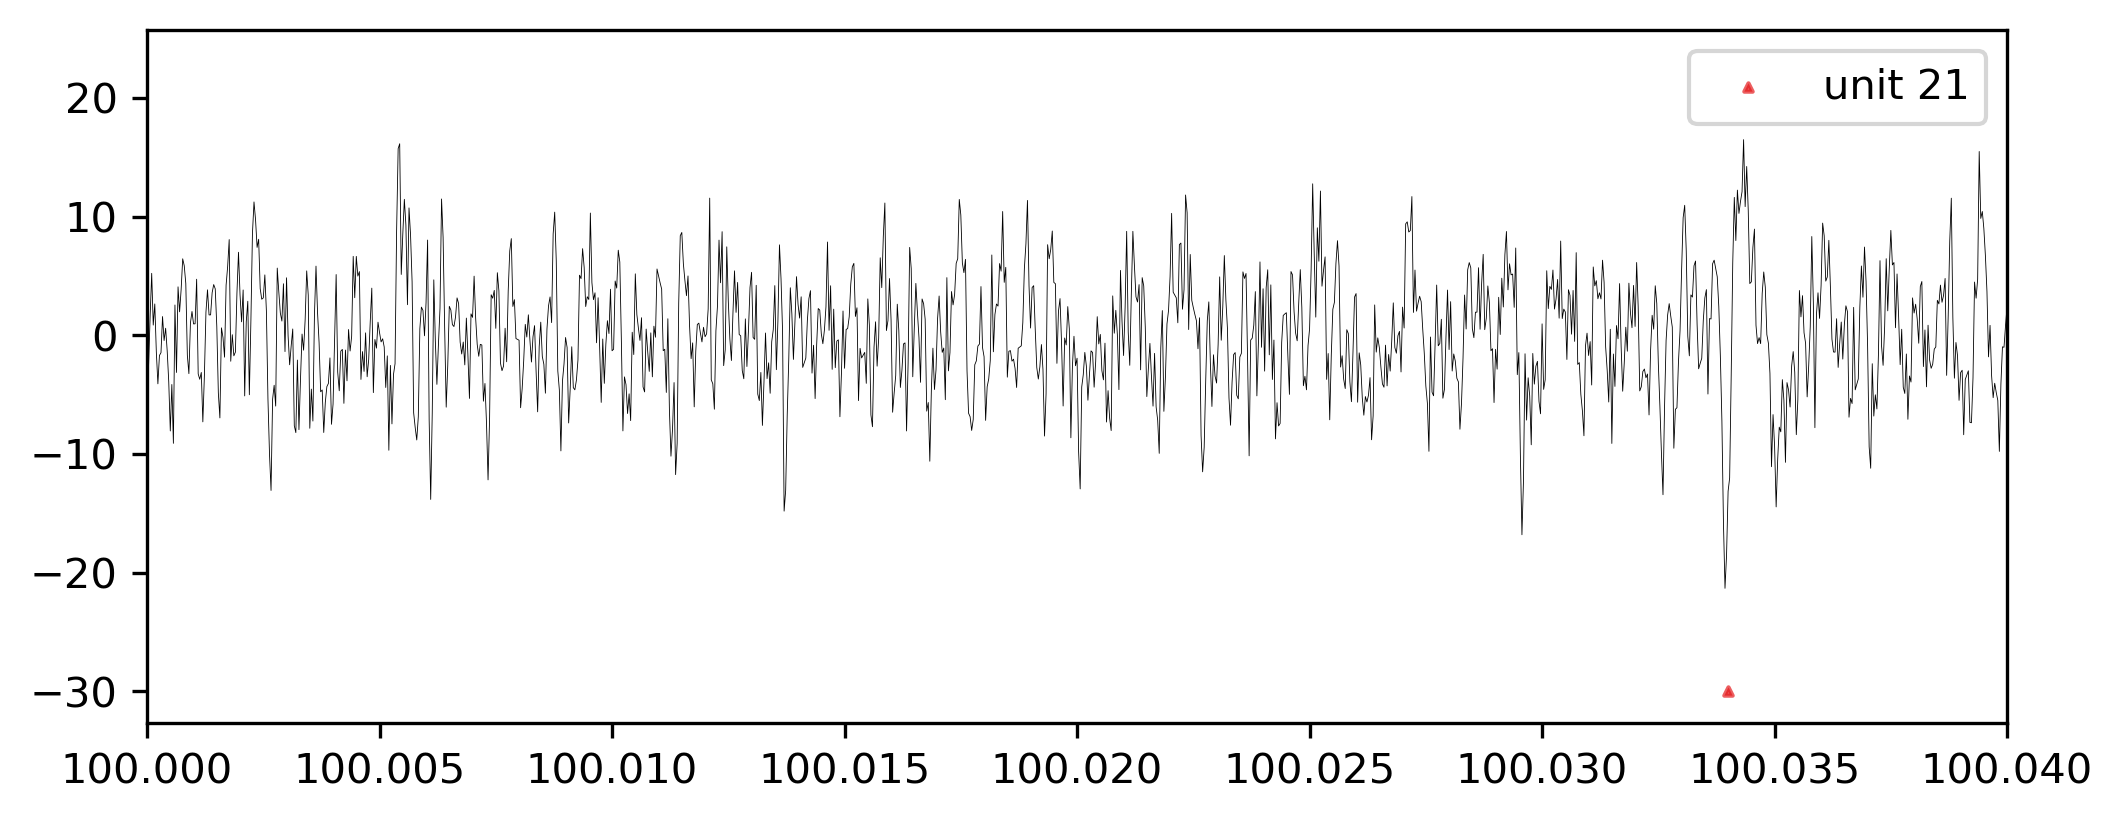

In [ ]:
channel_signals["ch13"].plot_signal(xlim=(100,100.04))
#plt.ylim((-20,20))

## WaveMAP Parameters

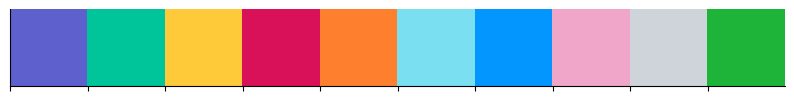

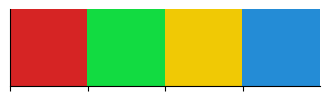

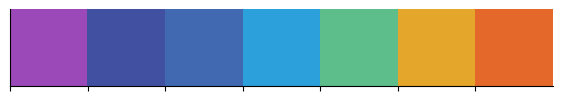

In [8]:
CUSTOM_PAL_SORT_3 = ['#5e60ce', '#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da', '#1eb43a']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283,	0.724],
[0.259,	0.314, 0.635],
[0.251,	0.412, 0.698],
[0.176,	0.631, 0.859],
[0.369,	0.749, 0.549],
[0.898,	0.654, 0.169],
[0.898,	0.41, 0.165]]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [162]:
#These are the depths that the V-probe channels are located at
DEPTHS = [0.15,0.3,0.45,0.60,0.75,0.9,1.05,1.20,1.35,1.50,1.65,1.80,1.95,2.1,2.25,2.4]

#This converts time points to real time. There are 62 samples per waveform collected at 30 kilosamples
SAMP_RATE_TO_TIME = 1/(62/30000) 

#Setting of random seed across Python kernel and packages to ensure reproducibility 
RAND_STATE=42
np.random.seed(RAND_STATE)
os.environ['PYTHONHASHSEED'] = str(RAND_STATE)
random.seed(RAND_STATE)

#UMAP Parameters
#The number of neighbors considered when constructing the high-d graph. 
#Made more global-information preserving by increasing it from 15 to 20.
N_NEIGHBORS = 15

#The minimum distance between points in the projected space.
#Used for visualization but doesn't affect clustering.
MIN_DIST = 0.1

#Louvain Clustering Parameters
RESOLUTION = 1.5

# BLUE COLOR
BlueCol = '\033[94m'

## WaveMAP Clustering

In [10]:
unit_labels = np.array(pd.DataFrame(wf)['cluId'], dtype=int)
unit_labels

array([ 17,  21,  22,  24,  35,  41,  48,  52,  64,  65,  80,  87,  91,
        95, 105, 116, 117, 123, 125, 129, 130, 135, 139, 140, 146, 150,
       153, 177, 213, 215, 227, 234, 239, 241, 247, 248, 249, 250, 251,
       255, 257, 260, 263, 265, 268, 269, 272, 274, 275, 278, 284, 286,
       287, 291, 292, 296, 298, 306, 310, 311, 313, 314, 315, 317, 322,
       323, 328, 329, 332, 333, 335, 336, 339, 340, 344, 346, 347, 348,
       350, 354, 356, 360, 362, 365, 374, 375, 378, 379, 380, 383, 389,
       392, 393, 396, 397, 398, 401, 403, 405, 410, 417, 418, 419, 423,
       429, 433, 435, 439, 441, 443, 447, 449, 469, 470, 473, 480, 491,
       496, 500, 502, 516, 519, 523, 526, 528, 530, 531, 539, 548, 552,
       554, 556, 557, 561, 572, 583, 585, 587])

In [13]:
n_waveform_samps = 50

# create n_units * n_waveform_samps length array to store waveform labels
waveform_unit_labels = []

for i in range(len(unit_labels)):
    for l in range(n_waveform_samps):
        waveform_unit_labels.append(unit_labels[i])

waveform_unit_labels = np.array(waveform_unit_labels)

In [257]:
mean_unit_waveforms = np.array(wf['waveforms']).mean(axis=2)
waveformz = (mean_unit_waveforms - mean_unit_waveforms.mean(axis=1)[:,None]) / np.abs(mean_unit_waveforms).max(axis=1)[:,None] # standardize
#waveformz = (mean_unit_waveforms - np.mean(mean_unit_waveforms)) / np.std(mean_unit_waveforms)

In [14]:
# randomly sample n_waveform_samps waveforms from each unit
# waveforms = []

# for u in range(len(unit_labels)):
#     wf_idx = np.random.choice(np.arange(wf['waveforms'][u].shape[1]), n_waveform_samps, replace=False)
#     for w in range(n_waveform_samps):
#         waveforms.append(wf['waveforms'][u][:,wf_idx[w]])

# waveforms = np.array(waveforms)
#waveformz = (waveforms - waveforms.mean(axis=1)[:,None]) / waveforms.std(axis=1)[:,None] # standardize

In [160]:
# plt.figure()
# for wav in waveforms:
#     plt.plot(wav, linewidth=0.03, color='k')

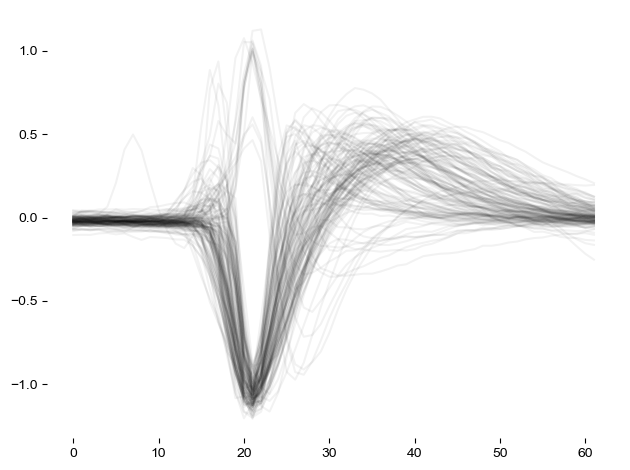

In [258]:
f,arr = plt.subplots(1)
arr.plot(waveformz.T,c='k',alpha=0.05);
f.tight_layout()
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)

In [259]:
reducer = umap.UMAP(n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST)#, 
                    #random_state=RAND_STATE)
mapper = reducer.fit(waveformz)
embedding = reducer.transform(waveformz)

umap_df = pd.DataFrame(embedding, columns=('x', 'y'))
umap_df['waveform'] = list(waveformz)

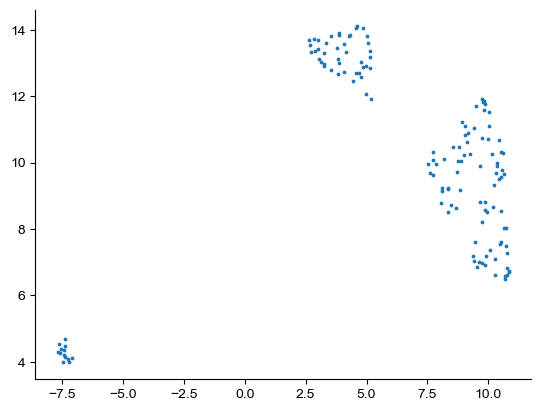

In [260]:
plt.scatter(umap_df.x,umap_df.y, s=3)

In [261]:
# add noise
noise = np.zeros(waveformz.shape)
for i,row in enumerate(noise):
    noise[i,:] = np.random.normal(0,0.11,waveformz.shape[1])
    
noisy_data = waveformz+noise

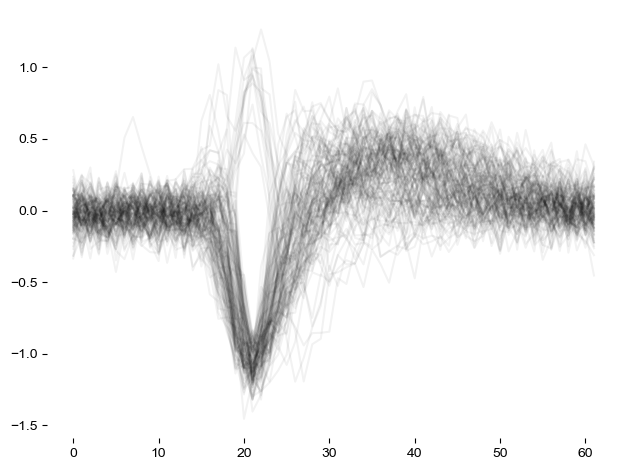

In [262]:
f,arr = plt.subplots(1)
arr.plot(noisy_data.T,c='k',alpha=0.05);
f.tight_layout()
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)

In [263]:
reducer_noise = umap.UMAP(n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, 
                          random_state=RAND_STATE)
mapper_noise = reducer.fit(noisy_data)
embedding_noise = reducer.transform(noisy_data)

umap_df_noise = pd.DataFrame(embedding_noise, columns=('x', 'y'))
umap_df_noise['waveform'] = list(noisy_data)

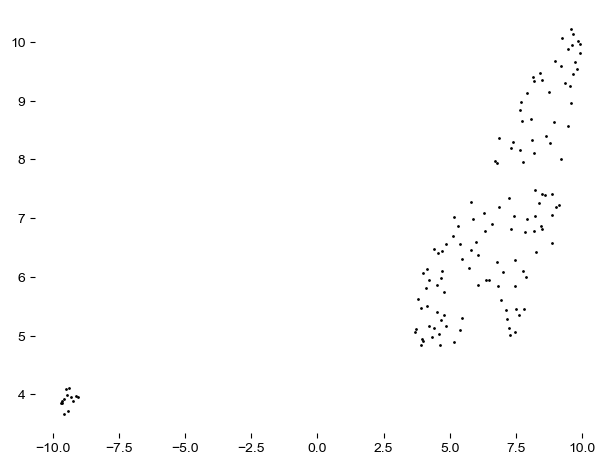

In [264]:
f,arr = plt.subplots(1)

f.tight_layout()
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.scatter(umap_df_noise.x,umap_df_noise.y,s=1,c='k')

In [265]:
# apply louvain clustering
G = nx.from_scipy_sparse_array(mapper.graph_)
clustering = louvain.best_partition(G, resolution=1.5)
#clustering = cylouvain.best_partition(G, resolution = RESOLUTION)
clustering_solution = list(clustering.values())
print(max(clustering_solution)+1)

7


In [266]:
umap_df['color'] = clustering_solution

cluster_colors = [CUSTOM_PAL_SORT_3[i] for i in clustering_solution]

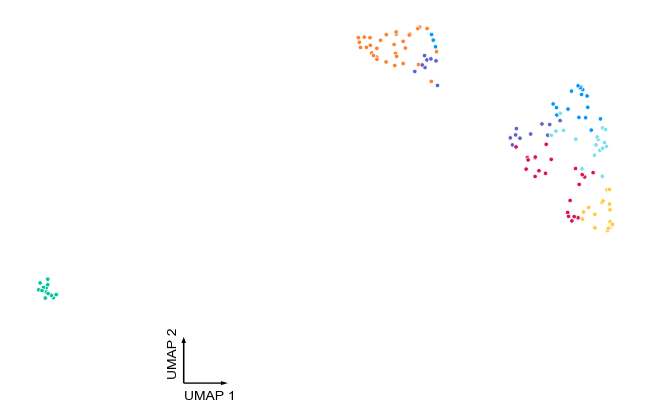

In [267]:
f,arr = plt.subplots(1,figsize=[7,4.5],tight_layout = {'pad': 0});
f.tight_layout()
arr.scatter(umap_df['x'].tolist(), umap_df['y'].tolist(), 
            marker='o', c=cluster_colors, s=10, edgecolor='w',
            linewidth=0.5)
arr.spines['top'].set_visible(False)
arr.spines['bottom'].set_visible(False)
arr.spines['left'].set_visible(False)
arr.spines['right'].set_visible(False)
arr.set_xticks([]);
arr.set_yticks([]);
#arr.set_xlim(-4,12)
#arr.set_ylim(0,12)

arr.arrow(-3,0.8,0,1.5, width=0.05, shape="full", ec="none", fc="black")
arr.arrow(-3,0.8,1.2,0, width=0.05, shape="full", ec="none", fc="black")

arr.text(-3,0.3,"UMAP 1", va="center")
arr.text(-3.5,1.0,"UMAP 2",rotation=90, ha="left", va="bottom")

N_CLUST = len(set(clustering_solution))

In [77]:
def extract_mean_kernels(labels, groups_df, n, fs):
    time_kernel_means = []
    frequency_kernel_means = []
    kernel_psd_means = []
    kernel_psd_ATKs = []

    for label_ix in range(1, N_CLUST+1):
        group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
        group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()

        time_kernels = []
        frequency_kernels = []
        kernel_psds = []    
        kernel_psds_ATK = []

        for waveform in group_waveforms:
            kernel_t,kernel_f,kernel_psd,freq_axis = gen_kernel(waveform, n, fs, center=True)
            time_kernels.append(kernel_t)
            frequency_kernels.append(kernel_f)
            kernel_psds.append(kernel_psd)
        
        time_kernel_mean = np.array(time_kernels).mean(axis=0)
        freq_kernel_mean = np.array(frequency_kernels).mean(axis=0)
        kernel_psd_mean = np.array(kernel_psds).mean(axis=0)

        _, __,kernel_psd_ATK,___ = gen_kernel(time_kernel_mean, n, fs, center=True)
        
        time_kernel_means.append(time_kernel_mean)
        frequency_kernel_means.append(freq_kernel_mean)
        kernel_psd_means.append(kernel_psd_mean)
        kernel_psd_ATKs.append(kernel_psd_ATK)

    mean_kernels = {
        "time_kernels":np.array(time_kernel_means),
        "freq_kernels": np.array(frequency_kernel_means),
        "kernel_psds": np.array(kernel_psd_means),
        "kernel_psds_ATK": np.array(kernel_psd_ATKs)
    }

    return mean_kernels, freq_axis

In [294]:
# Defines a nice function that plots all the waveforms in long column.
def plot_group(label_ix, labels, groups_df, colors, mean_only=False, detailed=False, arr=None):
    group_ixs = [i for i,x in enumerate(labels) if x == label_ix-1]
    group_waveforms = groups_df.iloc[group_ixs]['waveform'].tolist()
    
    if arr is None:
        f, arr = plt.subplots()
        f.set_figheight(1.8*1)#0.65)
        f.set_figwidth(3.0*1)#0.65)
    if not mean_only:
        for i,_ in enumerate(group_waveforms):
            arr.plot(group_waveforms[i],c=colors[label_ix-1],alpha=0.3,linewidth=1.5)
    
    if not mean_only:
        arr.plot(np.mean(group_waveforms,axis=0),c='k',linestyle='-')
    else:
        arr.plot(np.mean(group_waveforms,axis=0),c=colors[label_ix-1],linestyle='-')

    arr.spines['right'].set_visible(False)
    arr.spines['top'].set_visible(False)

    if detailed:
        
        avg_peak = np.mean([np.argmax(x) for x in group_waveforms[14:]])
        arr.axvline(avg_peak,color='k',zorder=0)
        
        arr.set_ylim([-5,5])
        arr.set_yticks([])
        #arr.set_xticks([0,7,14,21,28,35,42,48])
        arr.tick_params(axis='both', which='major', labelsize=12)
        #arr.set_xticklabels([0,'',0.5,'',1.0,'',1.5,''])
        arr.spines['left'].set_visible(False)
        arr.grid(False)
        #arr.set_xlim([0,48])

    if not detailed:
        arr.set(xticks=[],yticks=[])

        if not mean_only:
            x,y = 2.1,0.6
            ellipse = mpl.patches.Ellipse((x,y), width=5.4, height=0.3, facecolor='w',
                                 edgecolor='k',linewidth=1.5)
            label = arr.annotate(str(label_ix), xy=(x-0.25, y-0.08),fontsize=12, color = 'k', ha="center")
            arr.add_patch(ellipse)

            if i != -1:
                x, y = 40,-1
                n_waveforms = plt.text(x, y, 
                                       'n = '+str(len(group_waveforms))+
                                       ' ('+str(round(len(group_waveforms)/len(groups_df)*100,2))+'%)'
                                       , fontsize=10)
        #arr.set_ylim([-50, 50])
    if arr is None:
        return f, arr
    else:
        return arr

In [82]:
# fig, axes = plt.subplots(3,4, figsize=(9,7))
# for i in range(1, N_CLUST+1):
#     ax = axes.flatten()[i-1]
#     plot_group(i, clustering_solution, umap_df, CUSTOM_PAL_SORT_3, arr=ax)

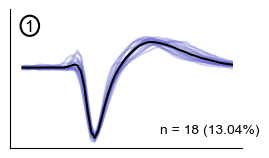

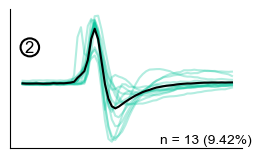

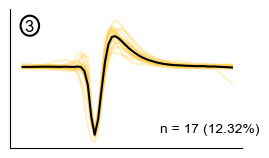

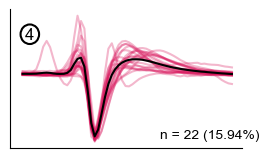

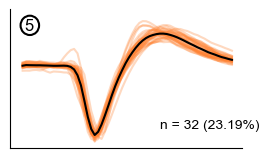

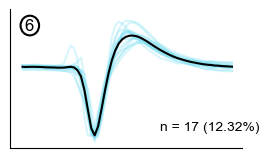

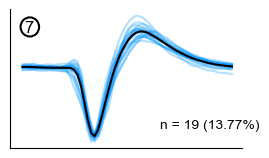

In [334]:
for i in range(1,N_CLUST+1):
    plot_group(i,clustering_solution,umap_df,CUSTOM_PAL_SORT_3)

In [ ]:
# wavemap_labels = np.array(clustering_solution)
# unit_waveform_clfs = np.zeros((len(unit_labels), n_waveform_samps))
# #unit_wavemap_labels = np.zeros(len(unit_labels), dtype=int)
# unit_wavemap_labels = {}

# for i in range(len(unit_labels)):
#     unit_waveform_clf = wavemap_labels[int(i*n_waveform_samps):int((i+1)*n_waveform_samps)]
#     unit_waveform_clfs[i] = unit_waveform_clf

#     unit_wavemap_label = scipy.stats.mode(unit_waveform_clf)[0]
#     unit_wavemap_labels[unit_labels[i]] = int(unit_wavemap_label)

In [191]:
# unit_samp_idx = np.random.choice(range(138), n_waveform_samps, replace=False)

# bins = np.arange(10)

# fig, axes = plt.subplots(5, 5, figsize=(12,12))
# for i,ax in enumerate(axes.flatten()[:n_waveform_samps]):
#     counts,_ = np.histogram(unit_waveform_clfs[unit_samp_idx[i]], bins=bins)

#     ax.bar(bins[:-1]+1, counts, color=CUSTOM_PAL_SORT_3[:9])
#     ax.set_xticks(bins[:-1]+1)
#     ax.set_title(f"Unit {unit_labels[unit_samp_idx[i]]}, Cluster {unit_wavemap_labels[unit_labels[unit_samp_idx[i]]]+1}")
# plt.tight_layout()

In [ ]:
# clf_conf = np.zeros(138)

# for i in range(138):
#     density,_ = np.histogram(unit_waveform_clfs[i], bins=bins, density=True)
#     clf_conf[i] = np.max(density)

In [283]:
avg_wavemap_wfs = []

for label_ix in range(1, N_CLUST+1):
    group_ixs = [i for i,x in enumerate(clustering_solution) if x == label_ix-1]
    group_waveforms = umap_df.iloc[group_ixs]['waveform'].tolist()
    
    avg_wavemap_wfs.append(np.mean(group_waveforms,axis=0))

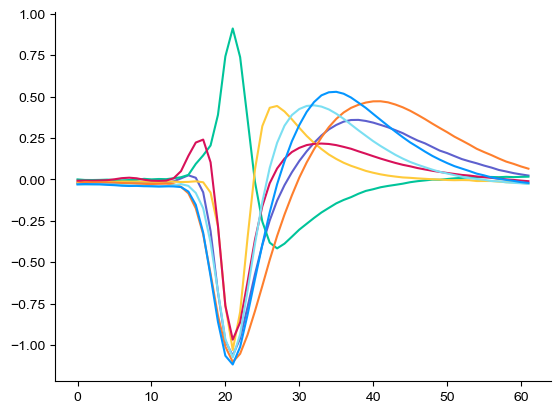

In [291]:
for i,clust_wf in enumerate(avg_wavemap_wfs):
    plt.plot(clust_wf, color=CUSTOM_PAL_SORT_3[i])

## Firing Rate Examination

In [307]:
unit_firing_rates = {}

for chan in chan_unit_dict:
    for u in chan_unit_dict[chan]:
        unit_firing_rates[u] = channel_signals[f'ch{chan}'].firing_rates[u]

In [977]:
np.save("wavemap_cluster_labels.npy", wavemap_cluster_labels)

In [825]:
wavemap_cluster_labels = np.array(clustering_solution)
unit_wavemap_label_dict = {}
wavemap_cluster_FRs = []

for i in range(N_CLUST):
    cluster_i_FRs = []
    for clust_unit in unit_labels[np.where(wavemap_cluster_labels == i)]:
        unit_wavemap_label_dict[clust_unit] = i
        if unit_firing_rates[clust_unit] > 0:
            cluster_i_FRs.append(unit_firing_rates[clust_unit])
    wavemap_cluster_FRs.append(cluster_i_FRs)

In [297]:
# wavemap_label_FRs = []
# wavemap_label_avgFRs = []

# for clust in range(9): # go through all clusters
#     clust_FRs = []

#     clust_units = unit_labels[np.array(list(unit_wavemap_labels.values())) == clust] # messy as hell
#     for cu in clust_units:
#         clust_FRs.append(unit_firing_rates[cu])

#     wavemap_label_FRs.append(clust_FRs)
#     wavemap_label_avgFRs.append(np.mean(clust_FRs))

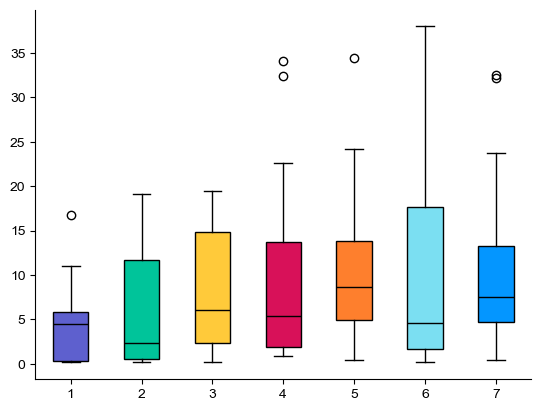

In [324]:
fig, ax = plt.subplots()

bplot = ax.boxplot(wavemap_cluster_FRs,
                   patch_artist=True,  # fill with color
                   tick_labels=range(1,8),
                   medianprops={'color': 'k'})

# fill with colors
for patch, color in zip(bplot['boxes'], CUSTOM_PAL_SORT_3[:-1]):
    patch.set_facecolor(color)

plt.show()

## Waveform Spectra

In [325]:
wavemap_kernels,freq_axis = extract_mean_kernels(clustering_solution, umap_df, fs, fs)

In [326]:
wavemap_kernels.keys()

dict_keys(['time_kernels', 'freq_kernels', 'kernel_psds', 'kernel_psds_ATK'])

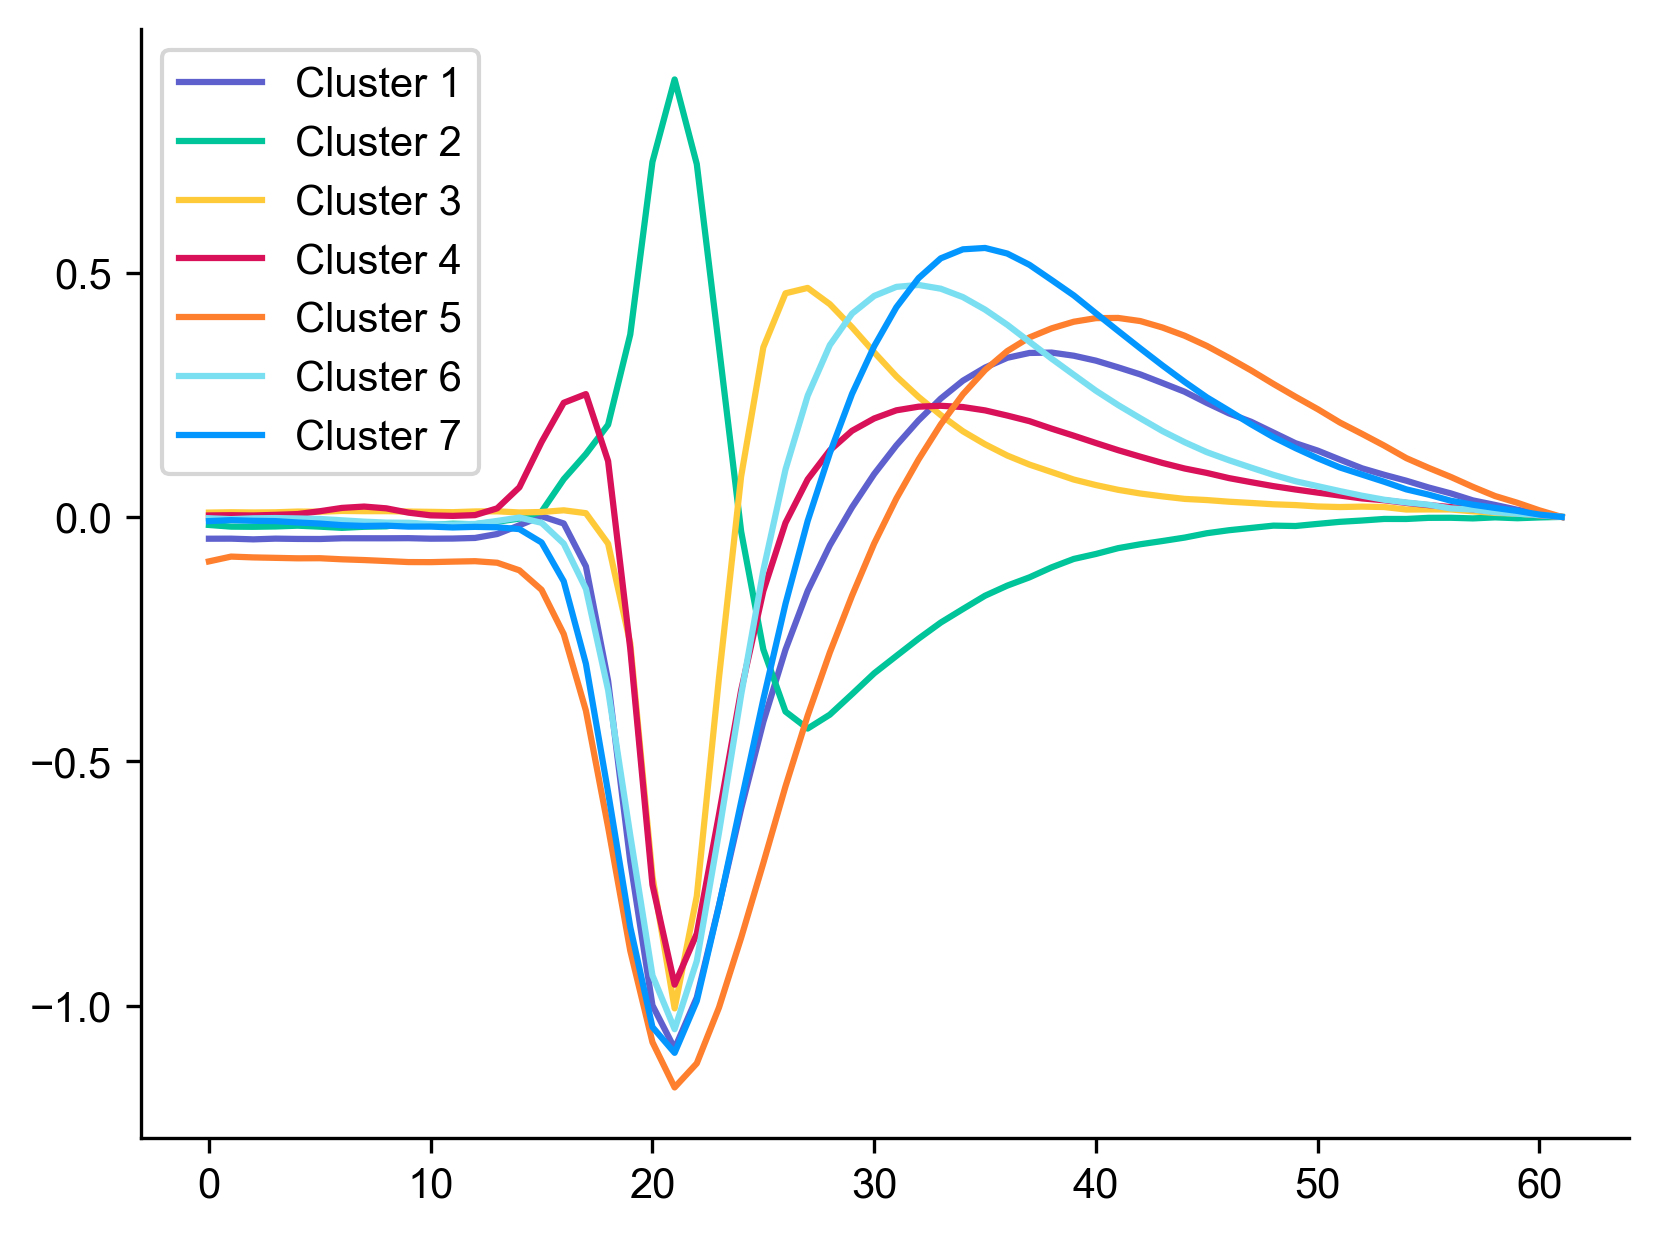

In [364]:
plt.figure(dpi=300)
for i in range(7):
    plt.plot(wavemap_kernels['time_kernels'][i,:62], color=CUSTOM_PAL_SORT_3[i], label=f'Cluster {i+1}')
plt.legend()
plt.show()

In [943]:
BROAD_NARROW_COLS = ['darkblue', 'darkgreen', 'darkred', 'darkred', 'darkblue', 'darkred', 'darkred']

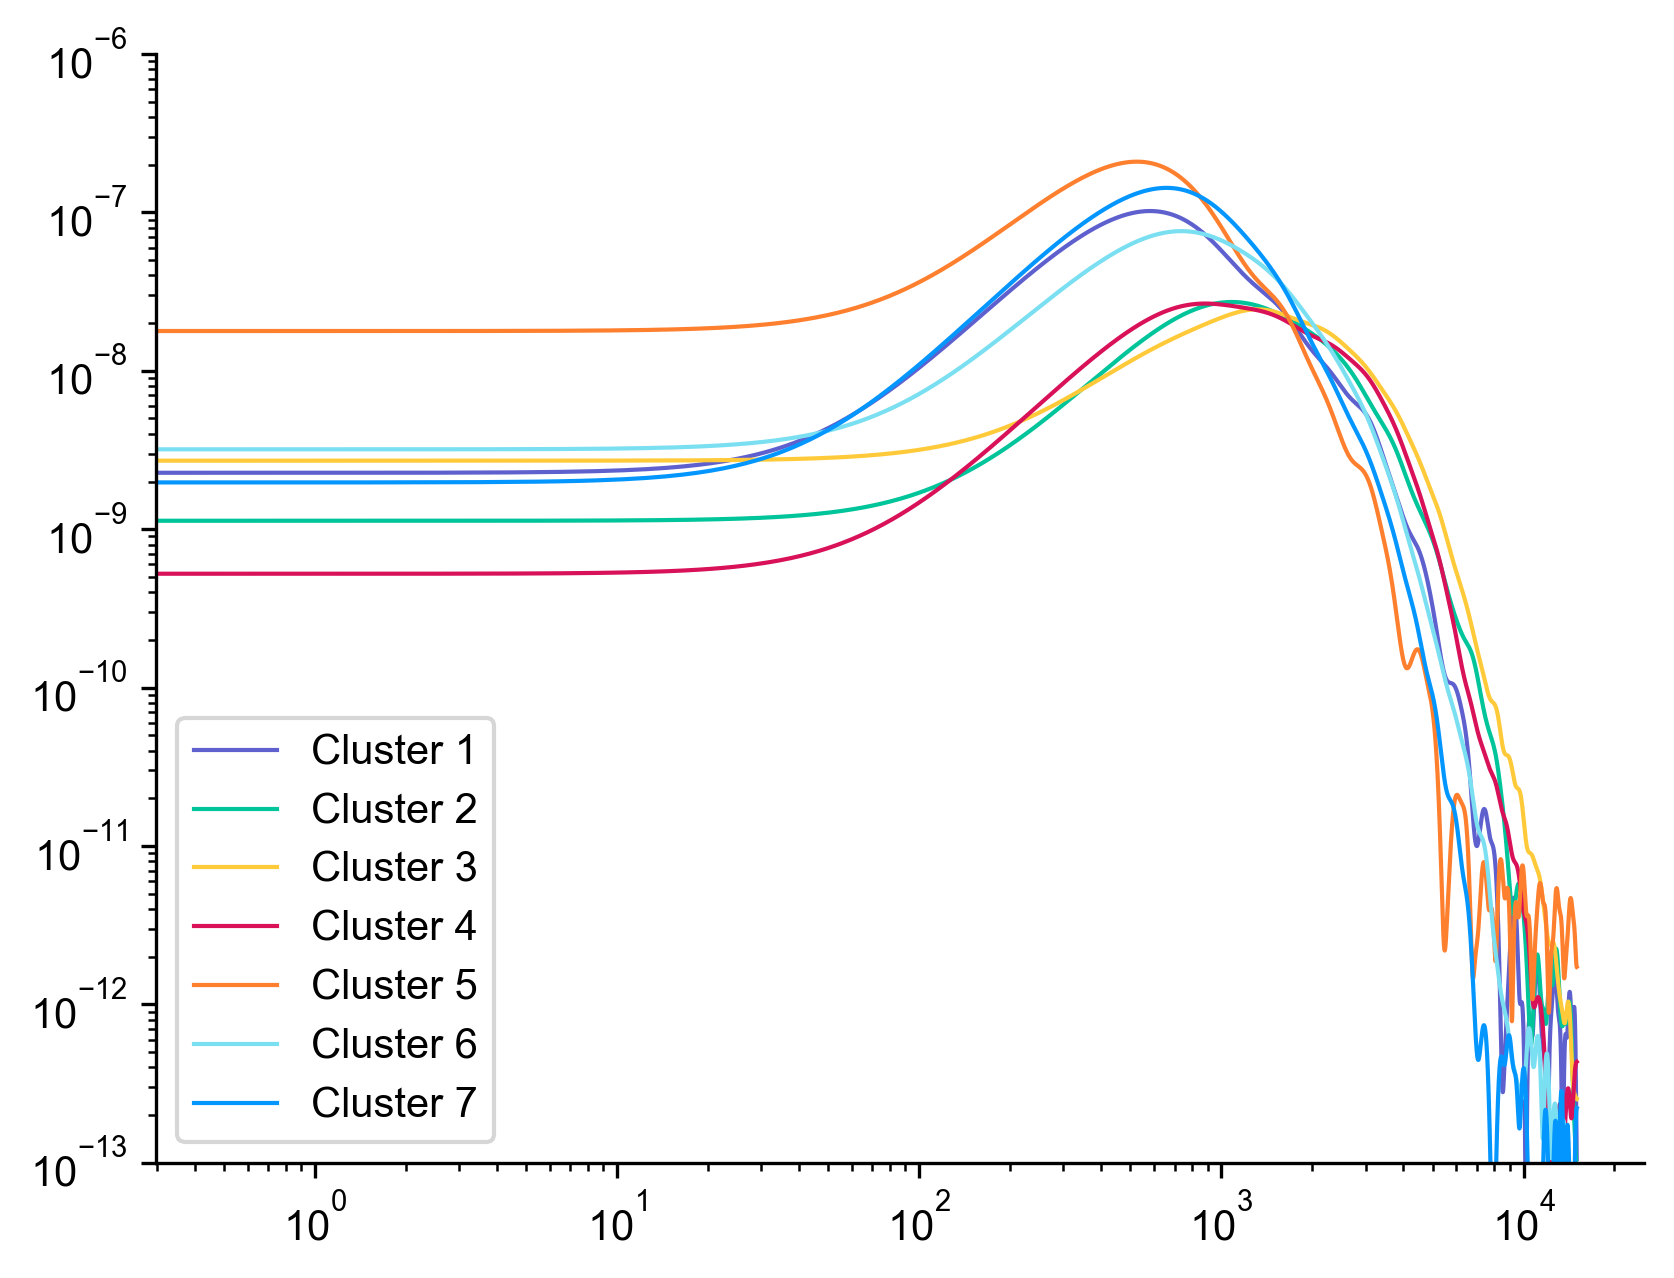

In [965]:
plt.figure(dpi=300)

for clust_idx in range(7):
    plt.loglog(freq_axis, wavemap_kernels['kernel_psds_ATK'][clust_idx], linewidth=1, label=f"Cluster {clust_idx+1}", color=CUSTOM_PAL_SORT_3[clust_idx])
plt.legend()
plt.ylim((1e-13,1e-6))
plt.show()

## Apply to channels

In [933]:
good_channels

array([ 15,  13,  14,  17,  23,  25,  25,  30,  38,  36,  46,  50,  52,
        55,  56,  62,  65,  67,  64,  70,  70,  71,  76,  73,  73,  72,
        77,  89, 120, 122, 132, 135, 136, 136, 140, 142, 144, 140, 141,
       148, 145, 146, 145, 150, 151, 148, 155, 156, 154, 152, 156, 162,
       160, 160, 160, 163, 166, 166, 168, 168, 169, 171, 172, 175, 172,
       177, 177, 177, 180, 181, 183, 182, 186, 184, 188, 189, 190, 188,
       188, 192, 195, 198, 198, 200, 205, 205, 208, 208, 209, 212, 216,
       219, 221, 221, 220, 221, 224, 226, 230, 228, 234, 232, 236, 237,
       240, 244, 246, 248, 252, 254, 258, 260, 278, 280, 282, 287, 298,
       302, 304, 309, 335, 336, 350, 352, 357, 356, 363, 368, 382, 176,
       201, 340, 204, 190, 142,  46, 240, 270])

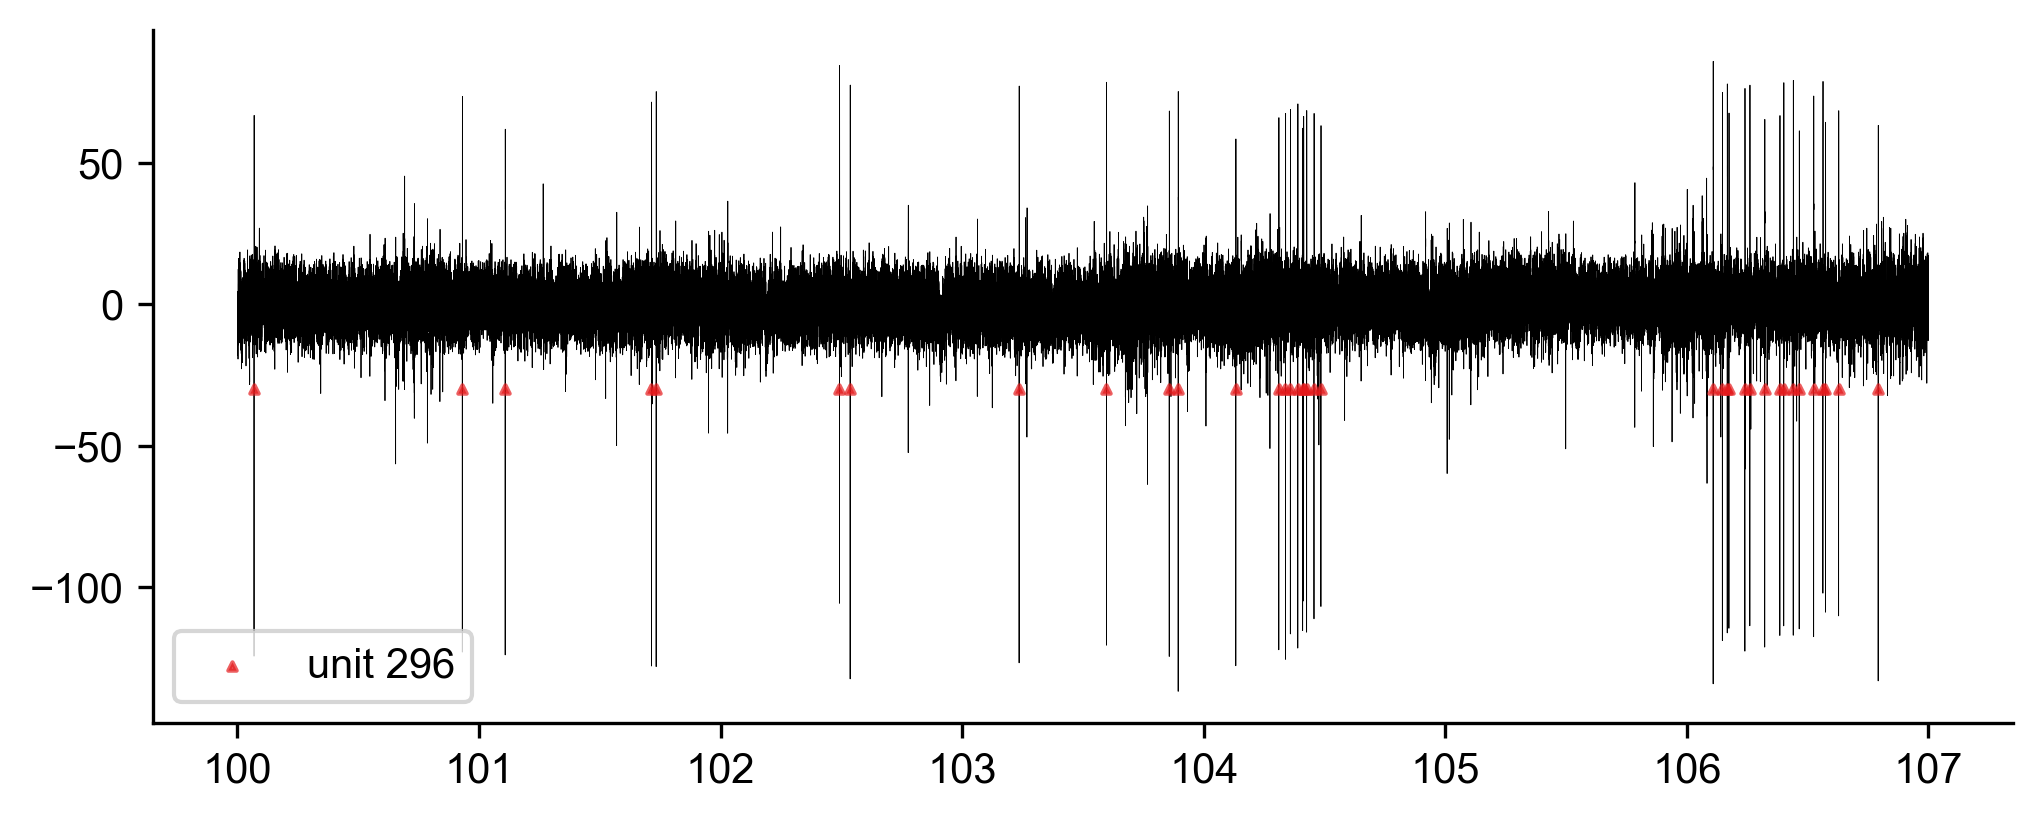

In [337]:
channel_signals['ch163'].plot_signal()

In [338]:
u296_instances,u296_kernels,theor_freqs = channel_signals['ch163'].generate_unit_kernels(selected_unit=296, truncate_idx=74)

In [346]:
wavemap_cluster_labels[np.where(unit_labels == 296)]

array([6])

In [341]:
ch163_PSD,mt_freqs = multitaper_psd(channel_signals['ch163'].time_series, fs, 7)

In [ ]:
def spectrum_smooth(spec, data_freqs, new_len, n_iters=200):
    """
    Samples from spectrum with exponentially decreasing probability with increasing frequency n_iters times
    and averages
    """
    wts = np.exp(-(1/spec.size)*np.arange(spec.size))
    wts /= wts.sum()    

    spec_samps = np.zeros((n_iters, new_len))
    freq_samps = np.zeros((n_iters, new_len))
    for i in range(n_iters):
        spec_idx = np.sort(np.random.choice(spec.size, new_len, replace=False, p=wts))
        freq_samps[i] = data_freqs[spec_idx]
        short_spec = spec[spec_idx]
        short_spec[60:][short_spec[60:] > 0.1] = np.mean(short_spec[60:1000])
        spec_samps[i] = short_spec

    spec_smooth = spec_samps.mean(axis=0)
    freq_smooth = freq_samps.mean(axis=0)

    spec_smooth[0] = spec[0]
    freq_smooth[0] = data_freqs[0]
    
    return spec_smooth, freq_smooth

In [704]:
u296_theor_PSD = u296_kernels['waveform_instance']['kernel_psd']*channel_signals['ch163'].firing_rates[296]

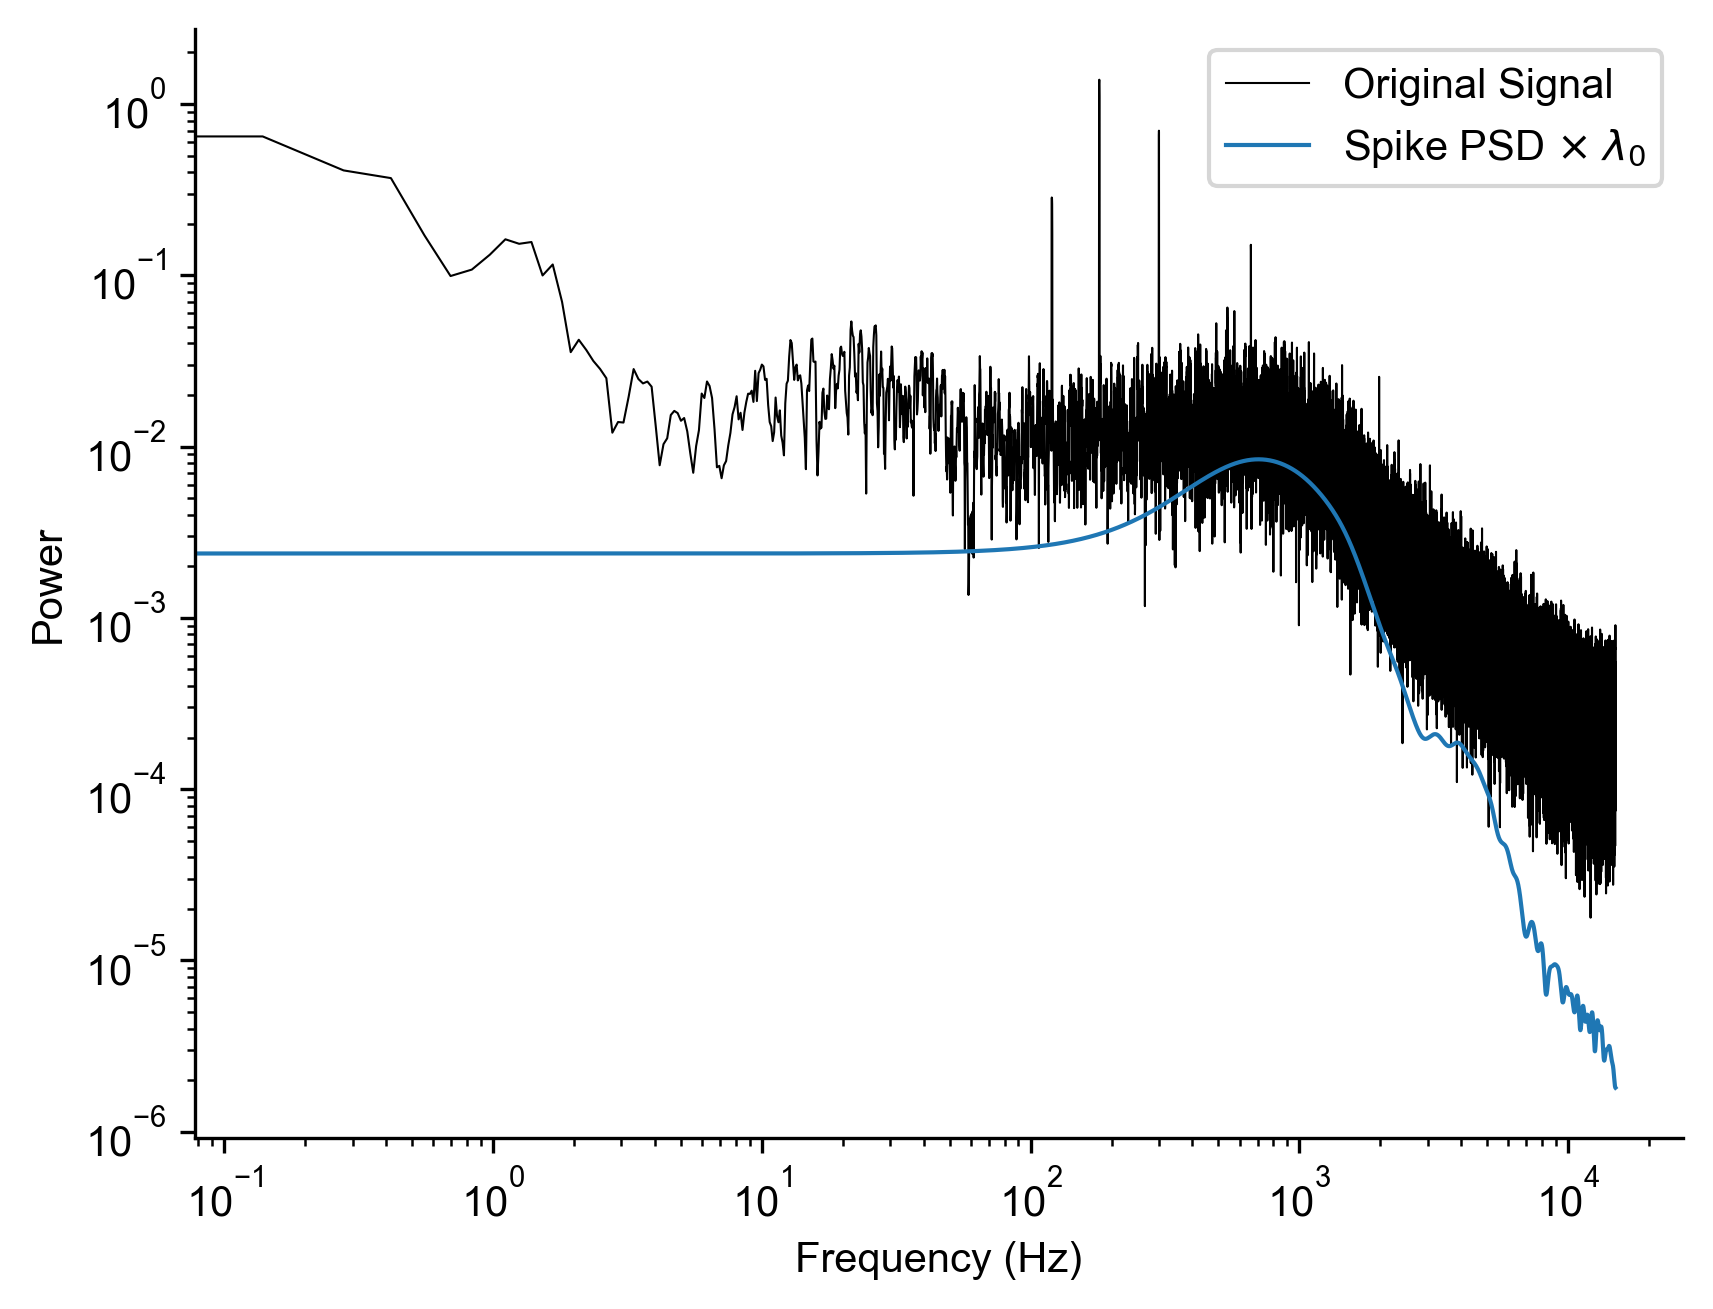

In [616]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch163_PSD, linewidth=0.5, color='k', label='Original Signal')
plt.loglog(theor_freqs, u296_theor_PSD, 
           linewidth=1,label=r'Spike PSD $\times$ $\lambda_0$')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.xlim((300,10000))
plt.legend()
plt.show()

In [ ]:
# individual_spk_arr = np.zeros((37, fs*(time_window[1]-time_window[0])))

# for i,spk_time in enumerate(channel_signals['ch163'].spike_times[296]):
#     individual_spk_arr[i,spk_time] = 1

#     exact_spk_instance = np.convolve(individual_spk_arr[i], u296_instances['waveforms'][i])

#     individual_spk_arr[i] = exact_spk_instance[20:-53]

# exact_spks = np.sum(individual_spk_arr, axis=0)

In [779]:
ch_time_series_WS = channel_signals['ch163'].time_series.copy()

for i,spk_time in enumerate(channel_signals['ch163'].spike_times[296]):
    ch_time_series_WS[int(spk_time-20):int(spk_time+54)] = np.random.normal(0, 8, 74)

#ch_time_series_WS = channel_signals['ch163'].time_series - exact_spks
ch_ts_WS_PSD,mt_freqs = multitaper_psd(ch_time_series_WS, fs, 7)

In [811]:
ch163_PSD_smooth, smooth_freqs = spectrum_smooth(ch163_PSD, mt_freqs, 15000, n_iters=500)
ch163_ws_PSD_smooth, smooth_freqs = spectrum_smooth(ch_ts_WS_PSD, mt_freqs, 15000, n_iters=500)

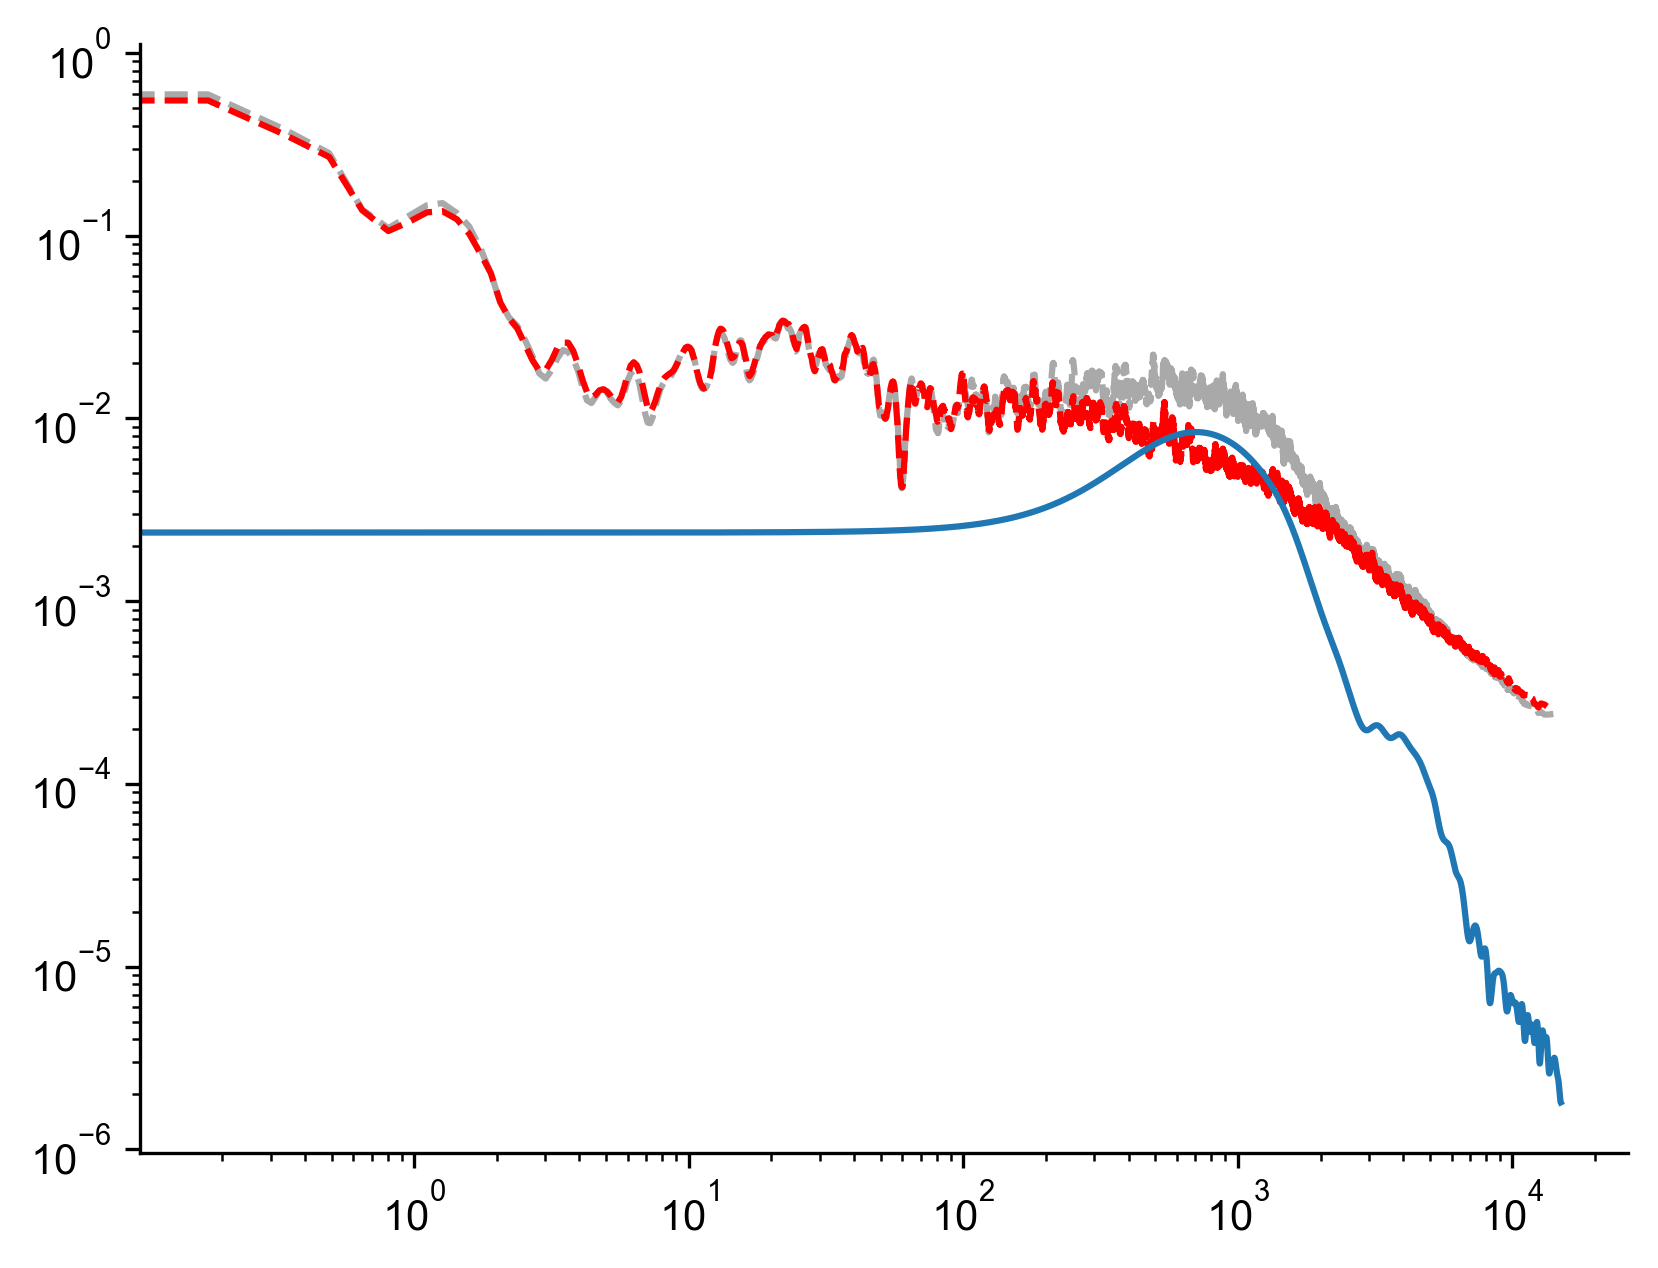

In [814]:
plt.figure(dpi=300)
plt.loglog(smooth_freqs, ch163_PSD_smooth, color='darkgray', linestyle='--')
plt.loglog(smooth_freqs, ch163_ws_PSD_smooth, color='red', linestyle='--')
plt.loglog(theor_freqs, u296_theor_PSD)
#plt.xlim((300, 2000))

## Lots of units again

In [717]:
add_spikes = [
    channel_signals['ch205'].spike_times[374],
    channel_signals['ch205'].spike_times[375]
]

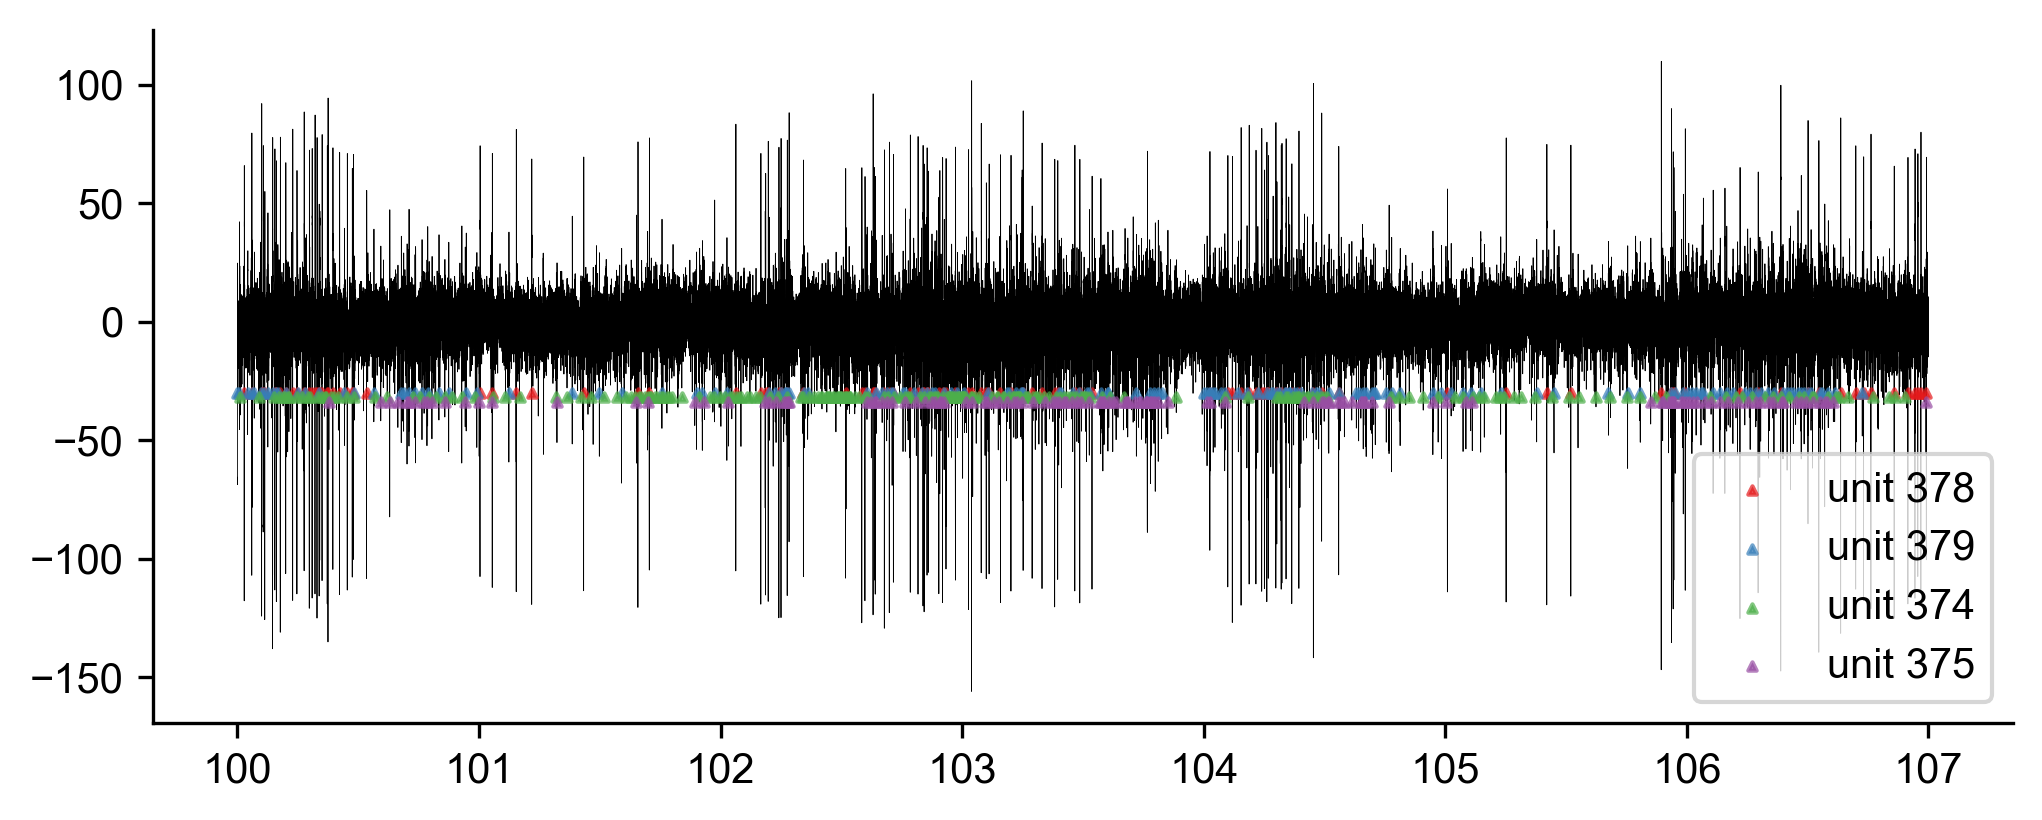

In [718]:
channel_signals['ch208'].plot_signal(additional_spikes=add_spikes, add_spk_units=[374, 375])

In [719]:
u378_instances,u378_kernels,theor_freqs = channel_signals['ch208'].generate_unit_kernels(selected_unit=378)
u379_instances,u379_kernels,theor_freqs = channel_signals['ch208'].generate_unit_kernels(selected_unit=379)

u374_instances,u374_kernels,theor_freqs = channel_signals['ch205'].generate_unit_kernels(selected_unit=374)
u375_instances,u375_kernels,theor_freqs = channel_signals['ch205'].generate_unit_kernels(selected_unit=375)

In [ ]:
def spec_sg_filt(spec, freqs, win_len_1=100, win_len_2=1000, split_idx=100, order=4):
    spec_split_1 = spec[freqs < split_idx]
    spec_split_2 = spec[freqs >= split_idx]

    spec_filt_1 = scipy.signal.savgol_filter(spec_split_1, win_len_1, order)
    spec_filt_2 = scipy.signal.savgol_filter(spec_split_2, win_len_2, order)

    return np.concatenate((spec_filt_1, spec_filt_2))

In [921]:
ch208_PSD,mt_freqs = multitaper_psd(channel_signals['ch208'].time_series, fs, 7)
#ch208_PSD_smooth, smooth_freqs = spectrum_smooth(ch208_PSD, mt_freqs, 15000, n_iters=200)
ch208_PSD_smooth = spec_sg_filt(ch208_PSD, mt_freqs, 100, 1000, 100, 4)

In [ ]:
ch_time_series_WS = channel_signals['ch208'].time_series.copy()
ch_isolated_spks = np.zeros((4,ch_time_series_WS.size))

sel_unit = 0

for spk_units in [378, 379]:
    for i,spk_time in enumerate(channel_signals['ch208'].spike_times[spk_units]):
        if spk_time < 20:
            spk_time = 20
        ch_time_series_WS[int(spk_time-20):int(spk_time+42)] = np.random.normal(0, 8, 62)
        ch_isolated_spks[sel_unit, int(spk_time-20):int(spk_time+42)] = channel_signals['ch208'].time_series[int(spk_time-20):int(spk_time+42)]
    sel_unit += 1

for spk_units in [374, 375]:
    for i,spk_time in enumerate(channel_signals['ch205'].spike_times[spk_units]):
        ch_time_series_WS[int(spk_time-20):int(spk_time+42)] = np.random.normal(0, 8, 62)
        ch_isolated_spks[sel_unit, int(spk_time-20):int(spk_time+42)] = channel_signals['ch205'].time_series[int(spk_time-20):int(spk_time+42)]
    sel_unit += 1

ch_ts_WS_PSD,mt_freqs = multitaper_psd(ch_time_series_WS, fs, 7)
ch_ts_IS1_PSD,_ = multitaper_psd(ch_isolated_spks[0], fs, 7)
ch_ts_IS2_PSD,_ = multitaper_psd(ch_isolated_spks[1], fs, 7)
ch_ts_IS3_PSD,_ = multitaper_psd(ch_isolated_spks[2], fs, 7)
ch_ts_IS4_PSD,_ = multitaper_psd(ch_isolated_spks[3], fs, 7)

In [922]:
ch208_ws_PSD_smooth = spec_sg_filt(ch_ts_WS_PSD, mt_freqs, 100, 1000, 100, 4)#, smooth_freqs = spectrum_smooth(ch_ts_WS_PSD, mt_freqs, 15000, n_iters=200)
ch208_is1_PSD_smooth = spec_sg_filt(ch_ts_IS1_PSD, mt_freqs, 100, 1000, 100, 4)#,_ = spectrum_smooth(ch_ts_IS1_PSD, mt_freqs, 15000, n_iters=500)
ch208_is2_PSD_smooth = spec_sg_filt(ch_ts_IS2_PSD, mt_freqs, 100, 1000, 100, 4)#,_ = spectrum_smooth(ch_ts_IS2_PSD, mt_freqs, 15000, n_iters=500)
ch205_is3_PSD_smooth = spec_sg_filt(ch_ts_IS3_PSD, mt_freqs, 100, 1000, 100, 4)#,_ = spectrum_smooth(ch_ts_IS3_PSD, mt_freqs, 15000, n_iters=500)
ch205_is4_PSD_smooth = spec_sg_filt(ch_ts_IS4_PSD, mt_freqs, 100, 1000, 100, 4)#,_ = spectrum_smooth(ch_ts_IS4_PSD, mt_freqs, 15000, n_iters=500)

In [841]:
cmap = colormaps.get_cmap('Set1')

In [845]:
u378_theor_PSD = u378_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch208'].firing_rates[378]
u379_theor_PSD = u379_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch208'].firing_rates[379]

u374_theor_PSD = u374_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch205'].firing_rates[374]
u375_theor_PSD = u375_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch205'].firing_rates[375]

(1e-05, 1)

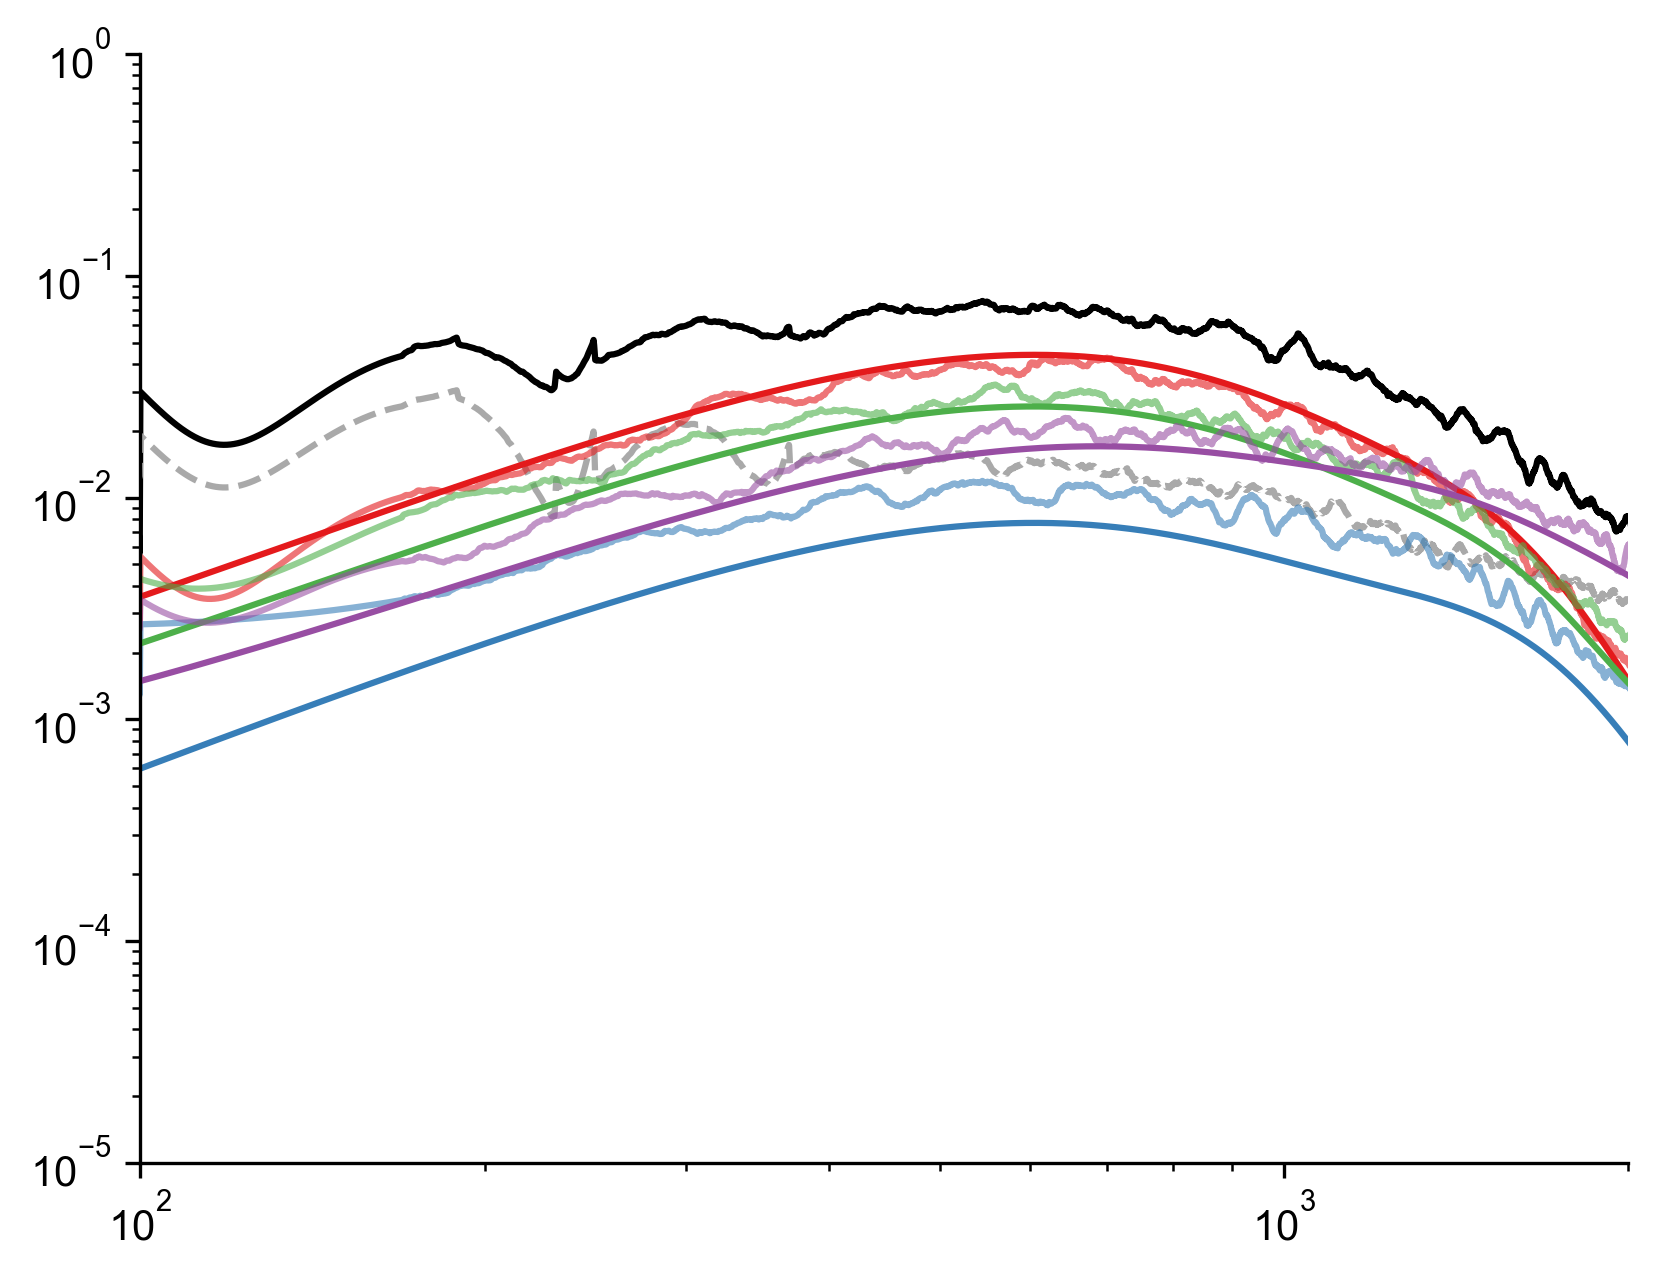

In [932]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch208_PSD_smooth, color='k')
plt.loglog(mt_freqs, ch208_ws_PSD_smooth, color='darkgrey', linestyle='--')

plt.loglog(mt_freqs, ch208_is1_PSD_smooth, alpha=0.6, color=cmap(0))
plt.loglog(theor_freqs, u378_theor_PSD, color=cmap(0))

plt.loglog(mt_freqs, ch208_is2_PSD_smooth, alpha=0.6, color=cmap(1))
plt.loglog(theor_freqs, u379_theor_PSD, color=cmap(1))

plt.loglog(mt_freqs, ch205_is3_PSD_smooth, alpha=0.6, color=cmap(2))
plt.loglog(theor_freqs, u374_theor_PSD, color=cmap(2))

plt.loglog(mt_freqs, ch205_is4_PSD_smooth, alpha=0.6, color=cmap(3))
plt.loglog(theor_freqs, u375_theor_PSD, color=cmap(3))

plt.xlim((100, 2000))
plt.ylim((1e-5, 1))

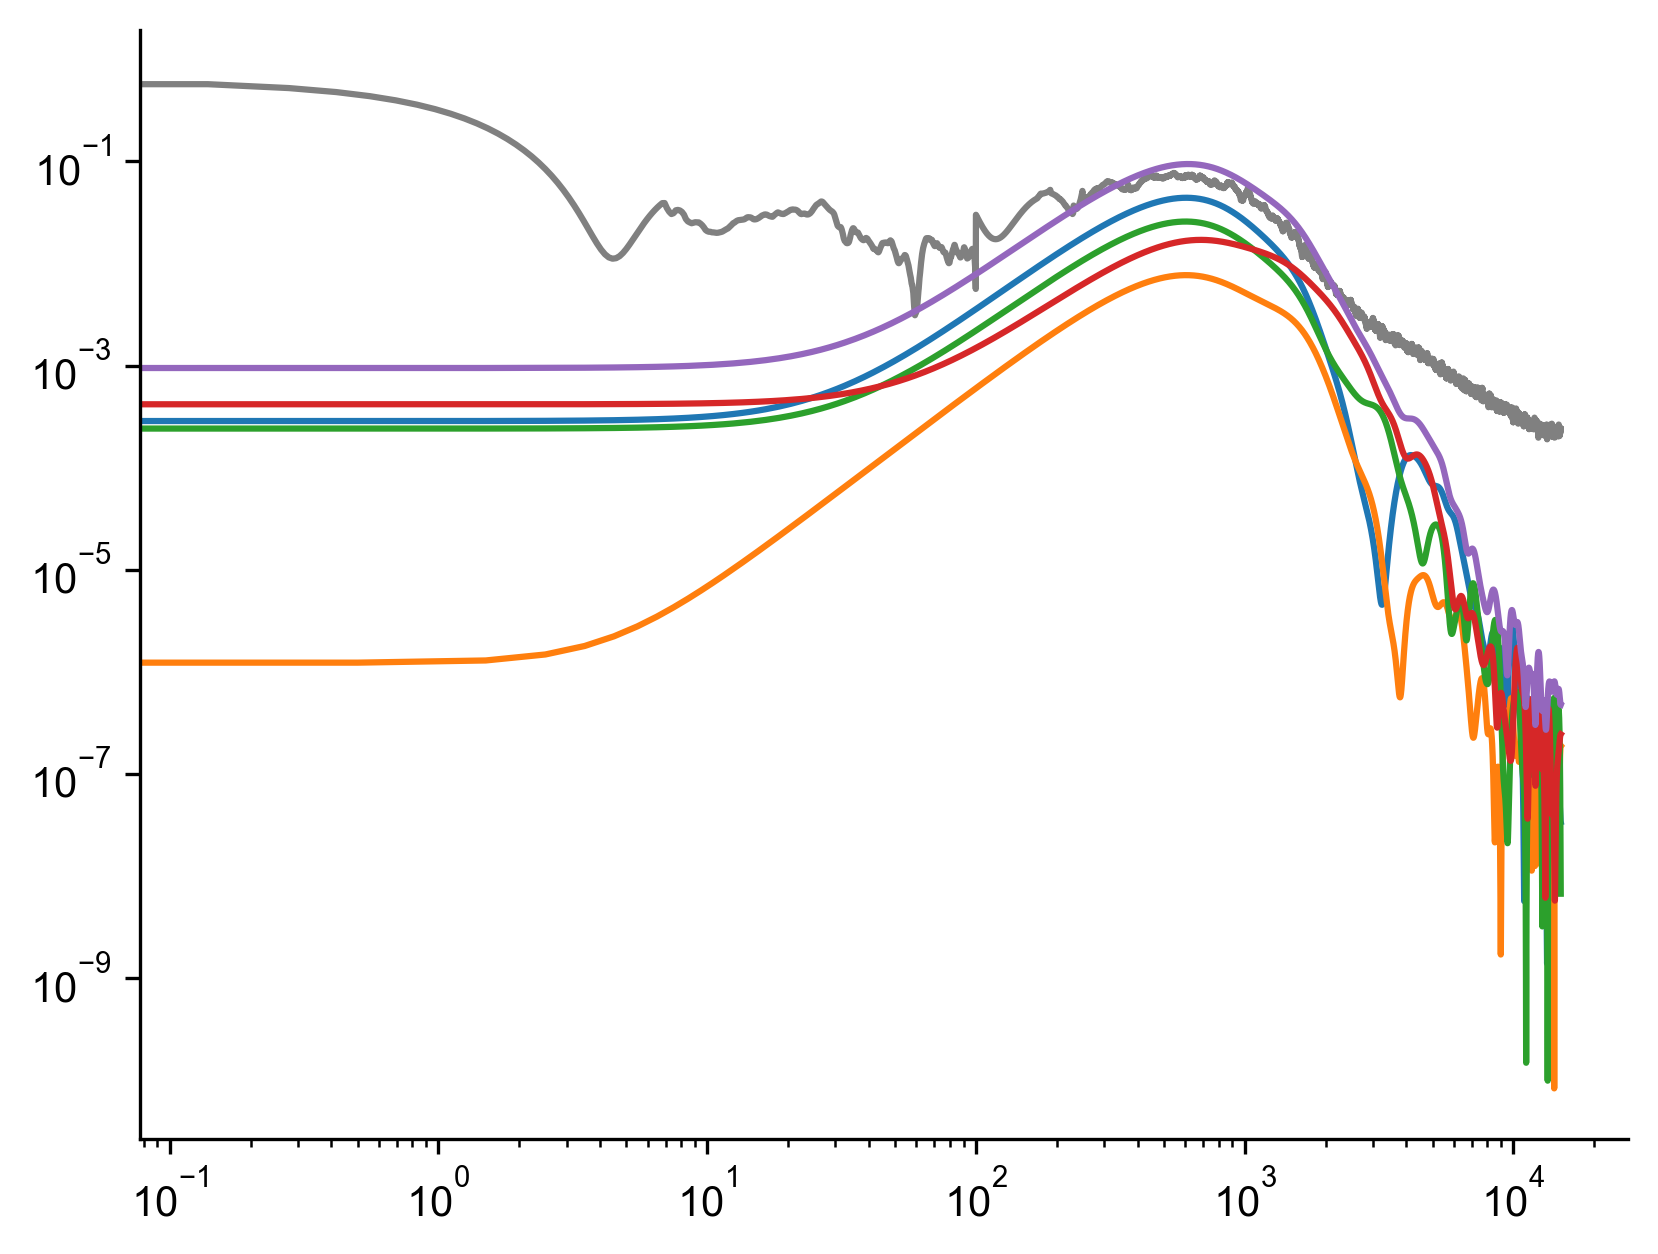

In [928]:
plt.figure(dpi=300)
#plt.loglog(mt_freqs, ch208_PSD, color='darkgrey')
plt.loglog(mt_freqs, ch208_PSD_smooth, color='grey')
plt.loglog(theor_freqs, u378_theor_PSD)
plt.loglog(theor_freqs, u379_theor_PSD)
plt.loglog(theor_freqs, u374_theor_PSD)
plt.loglog(theor_freqs, u375_theor_PSD)
plt.loglog(theor_freqs, u378_theor_PSD+u379_theor_PSD+u374_theor_PSD+u375_theor_PSD)

## Lots of units

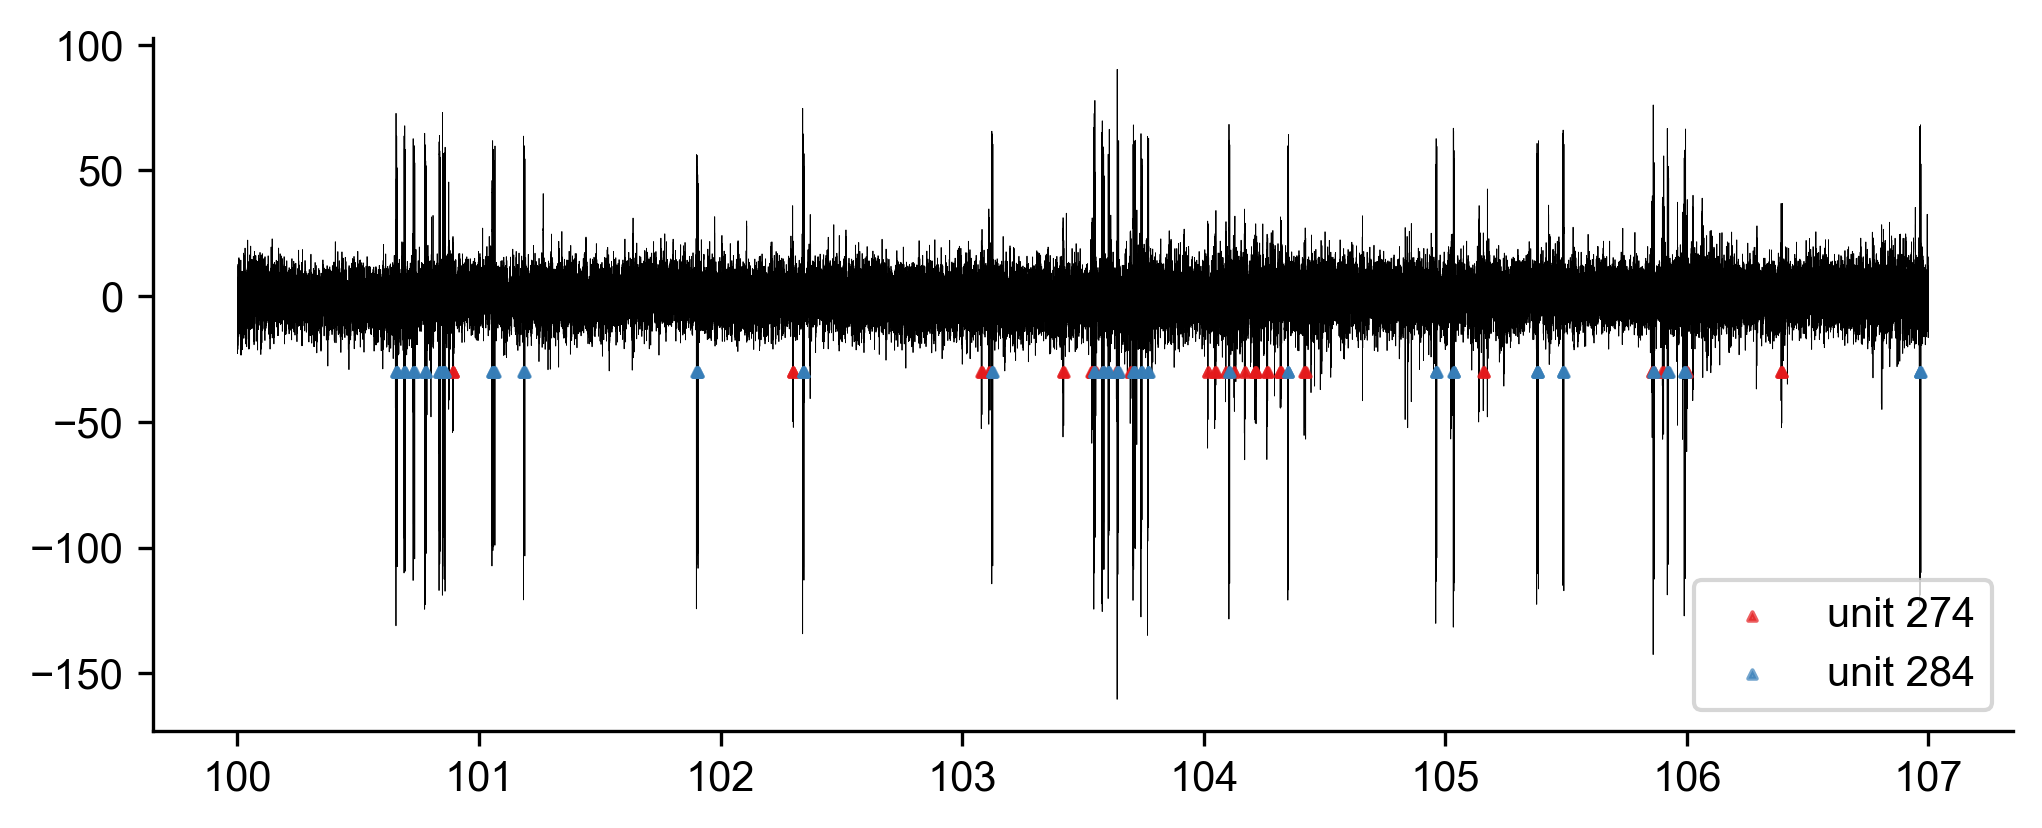

In [645]:
channel_signals['ch156'].plot_signal()

In [647]:
ch156_PSD,mt_freqs = multitaper_psd(channel_signals['ch156'].time_series, fs, 7)

In [663]:
u274_instances,u274_kernels,theor_freqs = channel_signals['ch156'].generate_unit_kernels(selected_unit=274, truncate_idx=52)
u284_instances,u284_kernels,theor_freqs = channel_signals['ch156'].generate_unit_kernels(selected_unit=284, truncate_idx=52)

In [680]:
u274_theor_PSD = u274_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch156'].firing_rates[274]
u284_theor_PSD = u284_kernels['waveform_instance']['kernel_psd_iaw'] * channel_signals['ch156'].firing_rates[284]

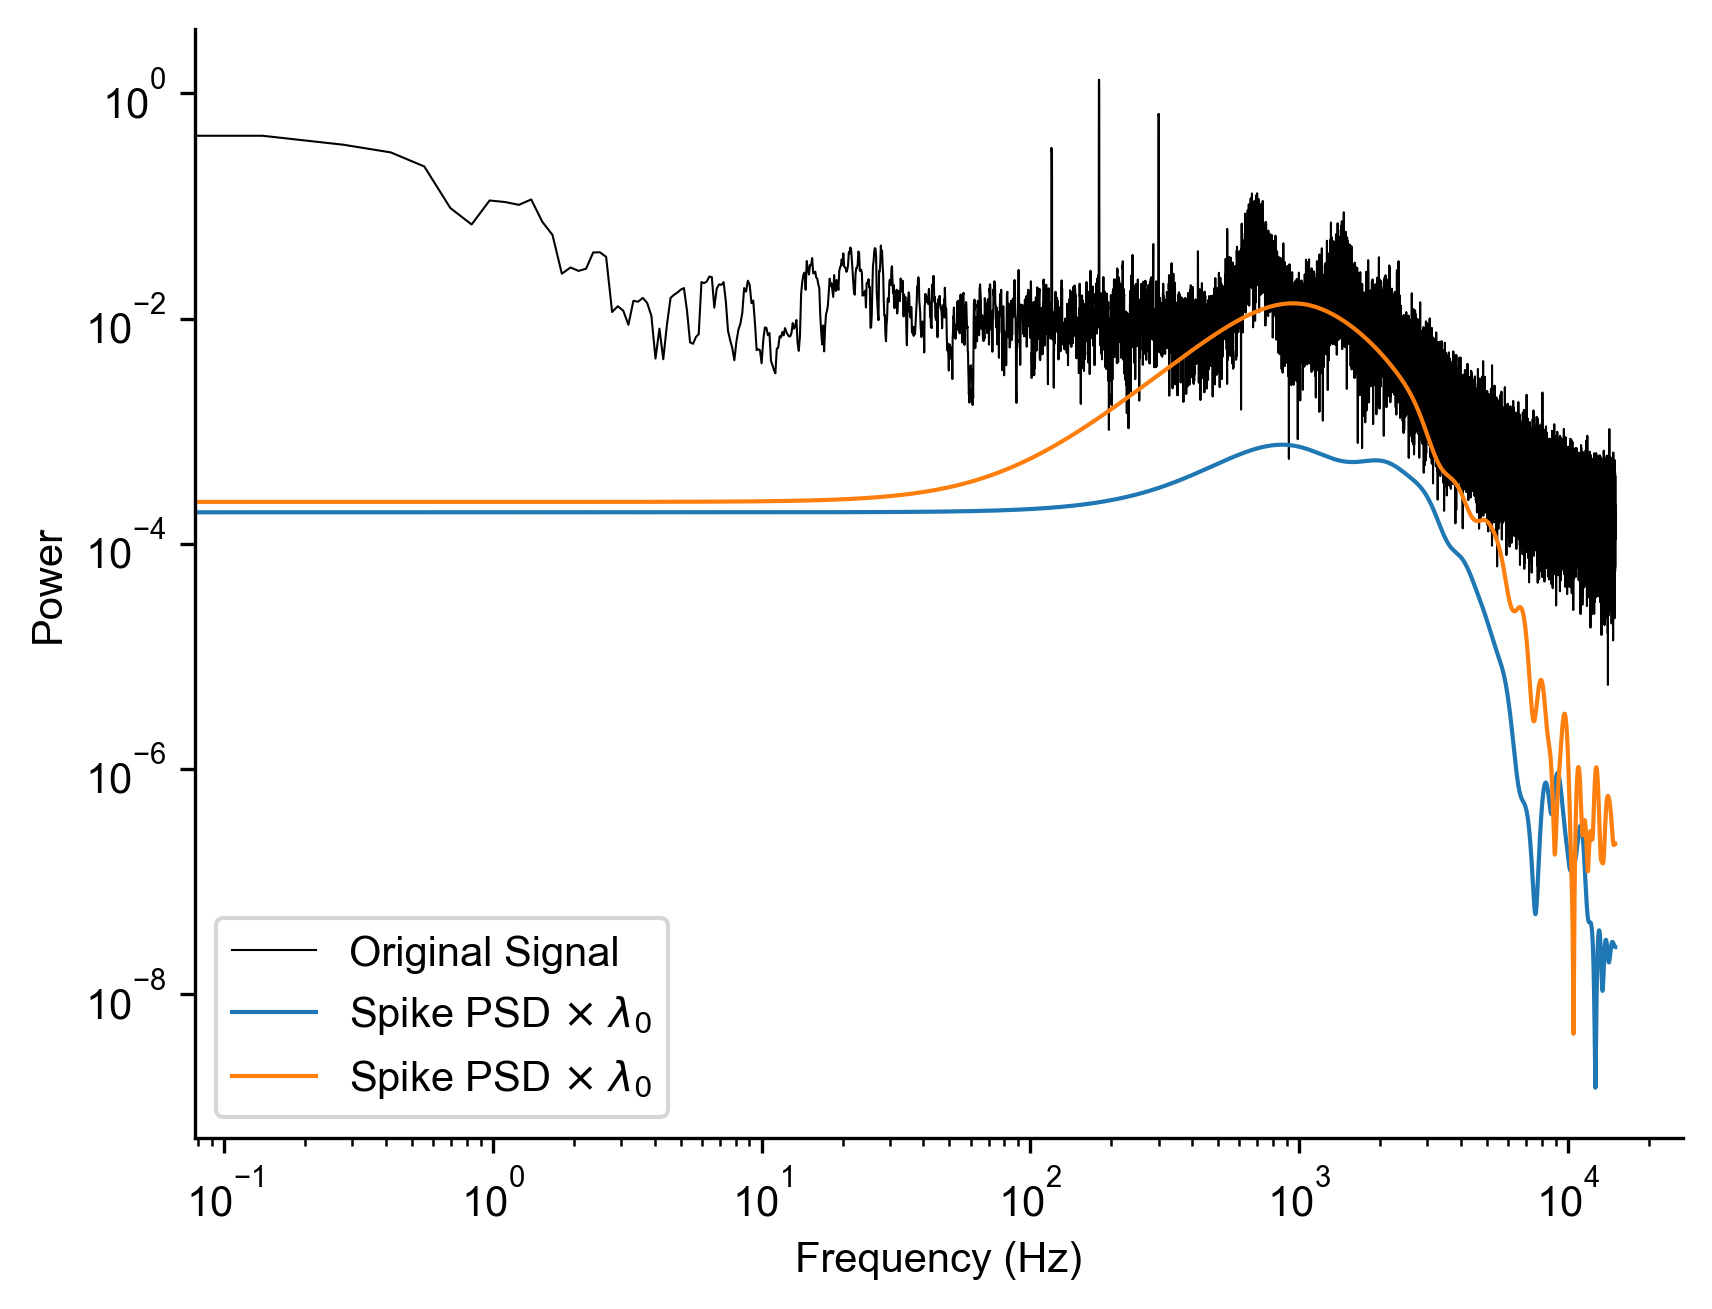

In [681]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch156_PSD, linewidth=0.5, color='k', label='Original Signal')
plt.loglog(theor_freqs, u274_theor_PSD, 
           linewidth=1,label=r'Spike PSD $\times$ $\lambda_0$')
plt.loglog(theor_freqs, u284_theor_PSD,
           linewidth=1,label=r'Spike PSD $\times$ $\lambda_0$')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
#plt.xlim((300,10000))
plt.legend()
plt.show()

In [ ]:
ch_time_series_WS = channel_signals['ch156'].time_series.copy()
ch_isolated_spks_u1 = np.zeros_like(ch_time_series_WS)
ch_isolated_spks_u2 = np.zeros_like(ch_time_series_WS)

for i,spk_time in enumerate(channel_signals['ch156'].spike_times[274]):
    ch_time_series_WS[int(spk_time-20):int(spk_time+32)] = np.random.normal(0, 8, 52)
    ch_isolated_spks_u1[int(spk_time-20):int(spk_time+32)] = channel_signals['ch156'].time_series[int(spk_time-20):int(spk_time+32)]

for i,spk_time in enumerate(channel_signals['ch156'].spike_times[284]):
    ch_time_series_WS[int(spk_time-20):int(spk_time+32)] = np.random.normal(0, 8, 52)
    ch_isolated_spks_u2[int(spk_time-20):int(spk_time+32)] = channel_signals['ch156'].time_series[int(spk_time-20):int(spk_time+32)]

ch_ts_WS_PSD,mt_freqs = multitaper_psd(ch_time_series_WS, fs, 7)
ch_ts_IS1_PSD,_ = multitaper_psd(ch_isolated_spks_u1, fs, 7)
ch_ts_IS2_PSD,_ = multitaper_psd(ch_isolated_spks_u2, fs, 7)

ch156_PSD_smooth, smooth_freqs = spectrum_smooth(ch156_PSD, mt_freqs, 15000, n_iters=200)
ch156_ws_PSD_smooth, smooth_freqs = spectrum_smooth(ch_ts_WS_PSD, mt_freqs, 15000, n_iters=200)
ch156_is1_PSD_smooth,_ = spectrum_smooth(ch_ts_IS1_PSD, mt_freqs, 15000, n_iters=200)
ch156_is2_PSD_smooth,_ = spectrum_smooth(ch_ts_IS2_PSD, mt_freqs, 15000, n_iters=200)

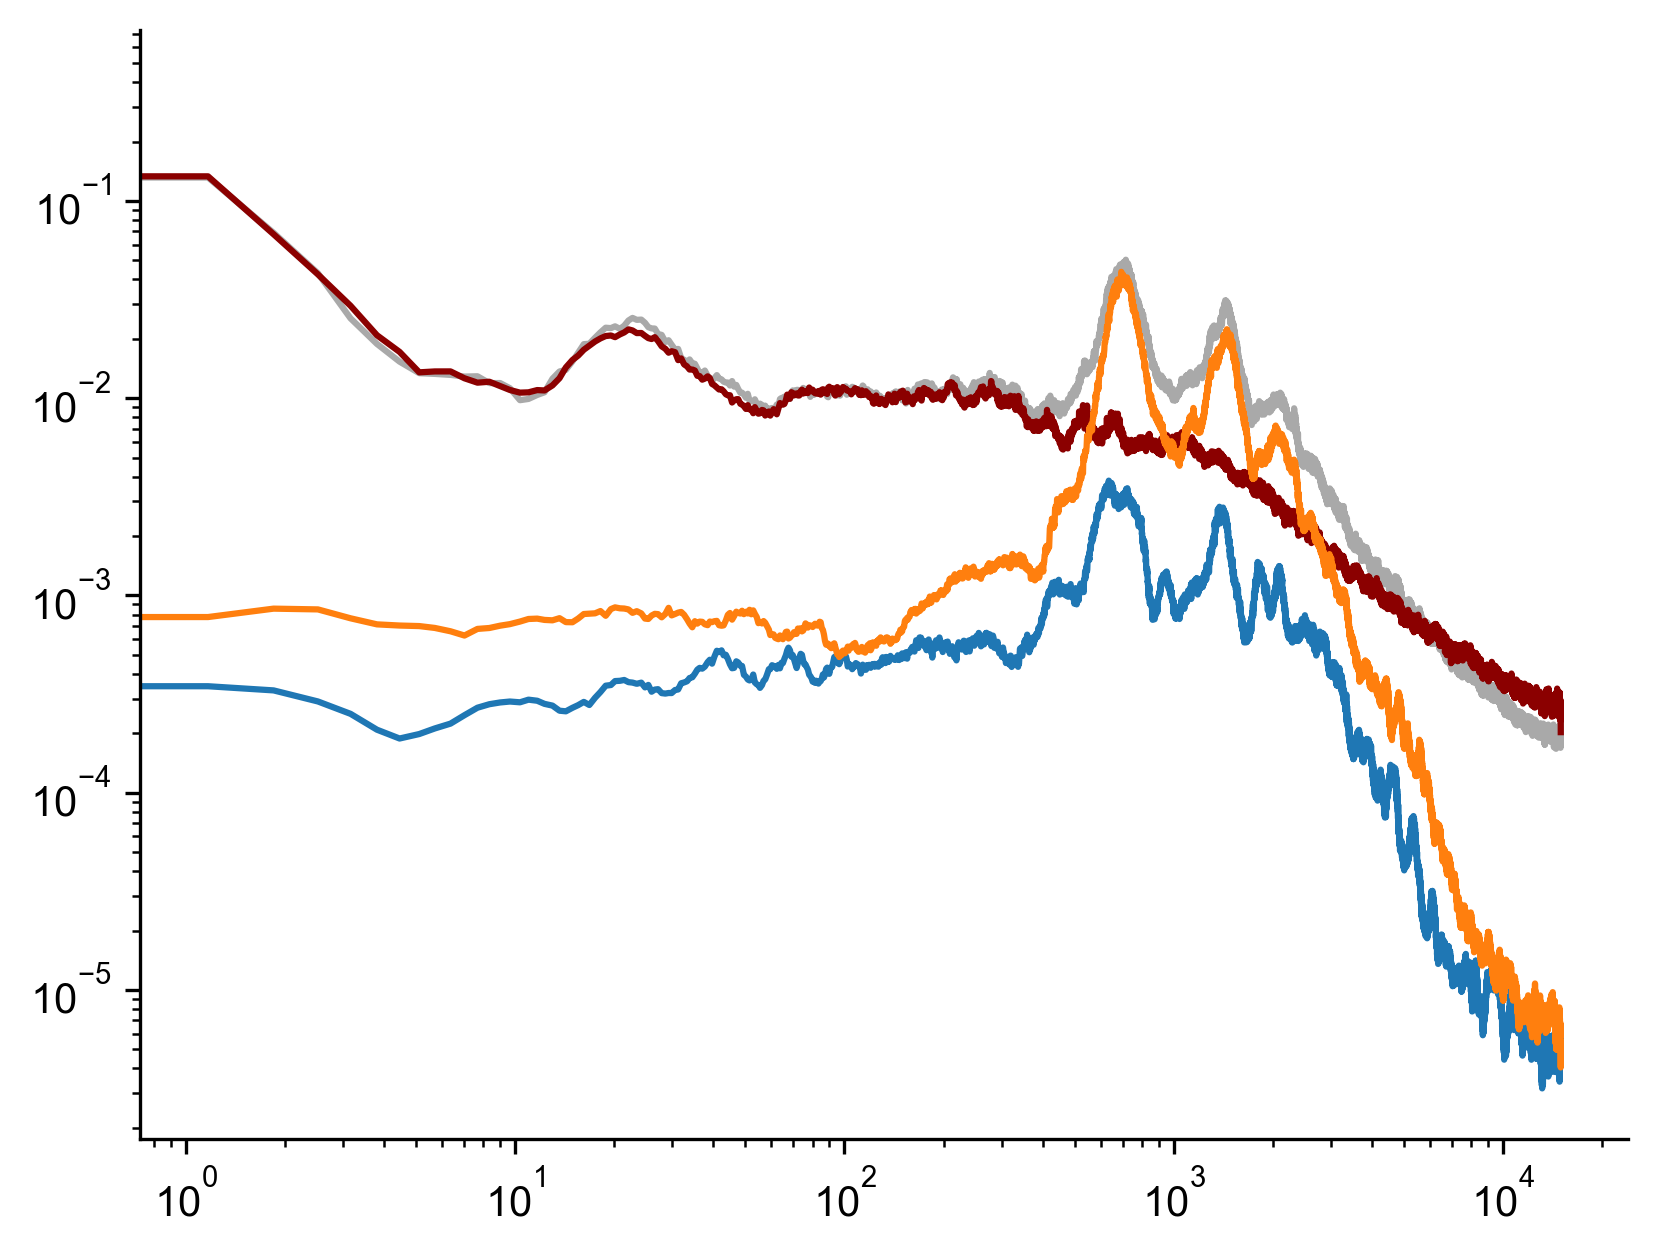

In [745]:
plt.figure(dpi=300)
plt.loglog(smooth_freqs, ch156_PSD_smooth, color='darkgrey')
plt.loglog(smooth_freqs, ch156_ws_PSD_smooth, color='darkred')
plt.loglog(smooth_freqs, ch156_is1_PSD_smooth)
plt.loglog(smooth_freqs, ch156_is2_PSD_smooth)

## More entangled signals

In [939]:
add_spikes = [
    channel_signals['ch160'].spike_times[287],
    channel_signals['ch160'].spike_times[291],
    channel_signals['ch160'].spike_times[292],
    channel_signals['ch166'].spike_times[298],
    channel_signals['ch166'].spike_times[306]
]

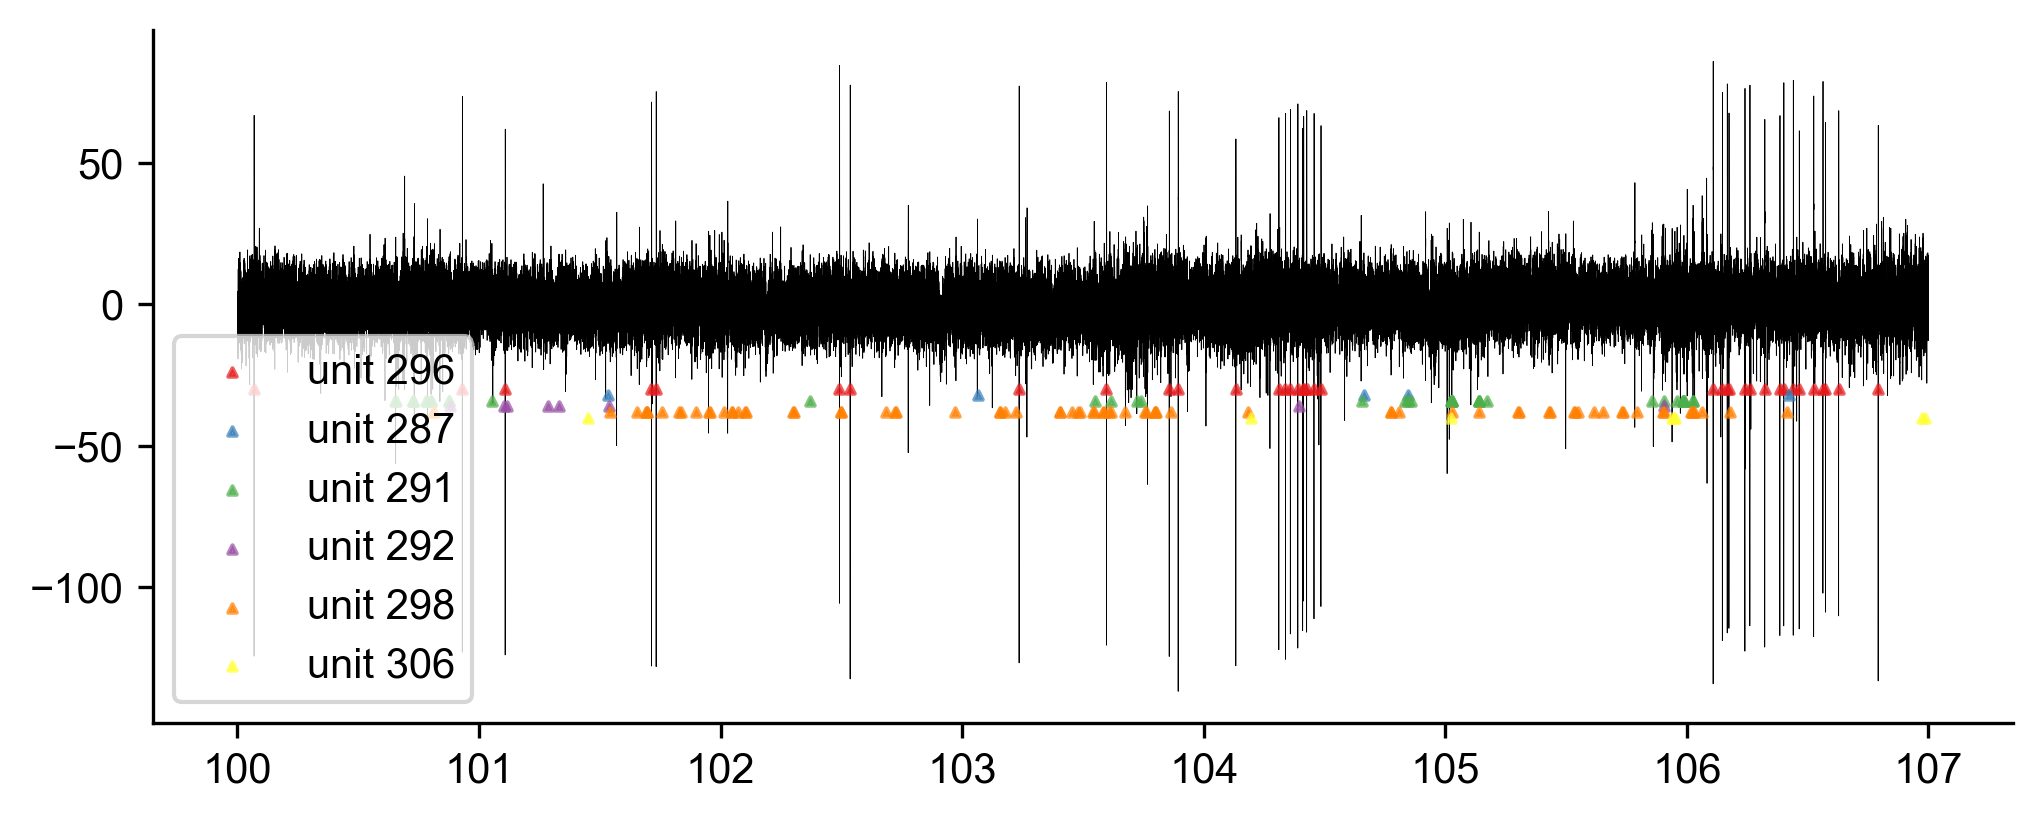

In [941]:
channel_signals['ch163'].plot_signal(additional_spikes=add_spikes, add_spk_units=[287, 291, 292, 298, 306])

In [946]:
u296_instances,u296_kernels,theor_freqs = channel_signals['ch163'].generate_unit_kernels(selected_unit=296)

u287_instances,u287_kernels,theor_freqs = channel_signals['ch160'].generate_unit_kernels(selected_unit=287)
u291_instances,u291_kernels,theor_freqs = channel_signals['ch160'].generate_unit_kernels(selected_unit=291)
u292_instances,u292_kernels,theor_freqs = channel_signals['ch160'].generate_unit_kernels(selected_unit=292)

u298_instances,u298_kernels,theor_freqs = channel_signals['ch166'].generate_unit_kernels(selected_unit=298)
u306_instances,u306_kernels,theor_freqs = channel_signals['ch166'].generate_unit_kernels(selected_unit=306)

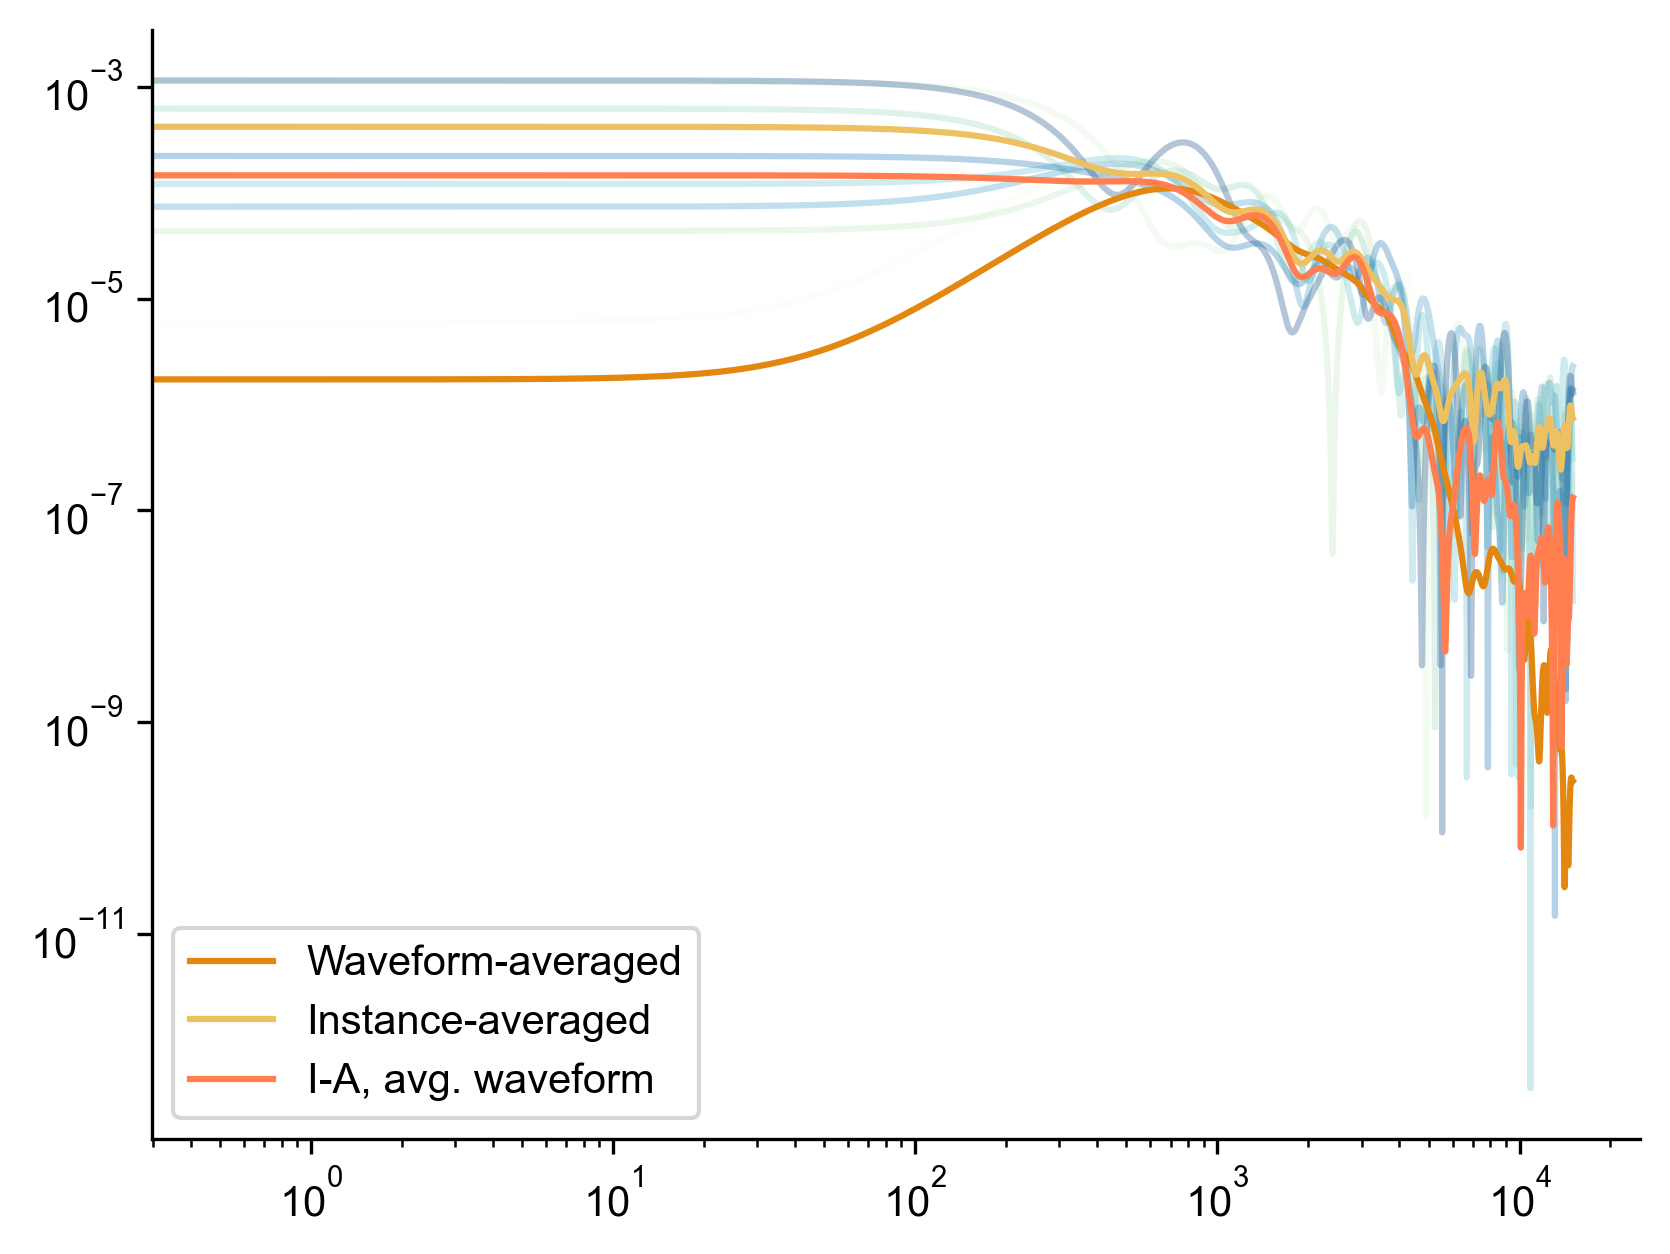

In [975]:
plot_ia_kernels(u306_instances['waveforms'], u306_instances['psds'],
                u306_kernels['average_waveform'], u306_kernels['waveform_instance'],
                theor_freqs, u306_instances['spikes'], kernel_type='psd')

In [954]:
ch163_PSD_smooth = spec_sg_filt(ch163_PSD, mt_freqs, 50, 1000, 100, 4)

In [960]:
chan163_unit_frs = [
    channel_signals['ch163'].firing_rates[296],
    channel_signals['ch160'].firing_rates[287],
    channel_signals['ch160'].firing_rates[291],
    channel_signals['ch160'].firing_rates[292],
    channel_signals['ch166'].firing_rates[298],
    channel_signals['ch166'].firing_rates[306]
]

In [959]:
channel_signals['ch160'].firing_rates

{287: 0.7142857142857143, 291: 5.571428571428571, 292: 1.1428571428571428}

In [968]:
chan163_theor_psds = [
    u296_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[0],
    u287_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[1],
    u291_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[2],
    u292_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[3],
    u298_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[4],
    u306_kernels['average_waveform']['kernel_psd'] * chan163_unit_frs[5]
]

(6, 30000)

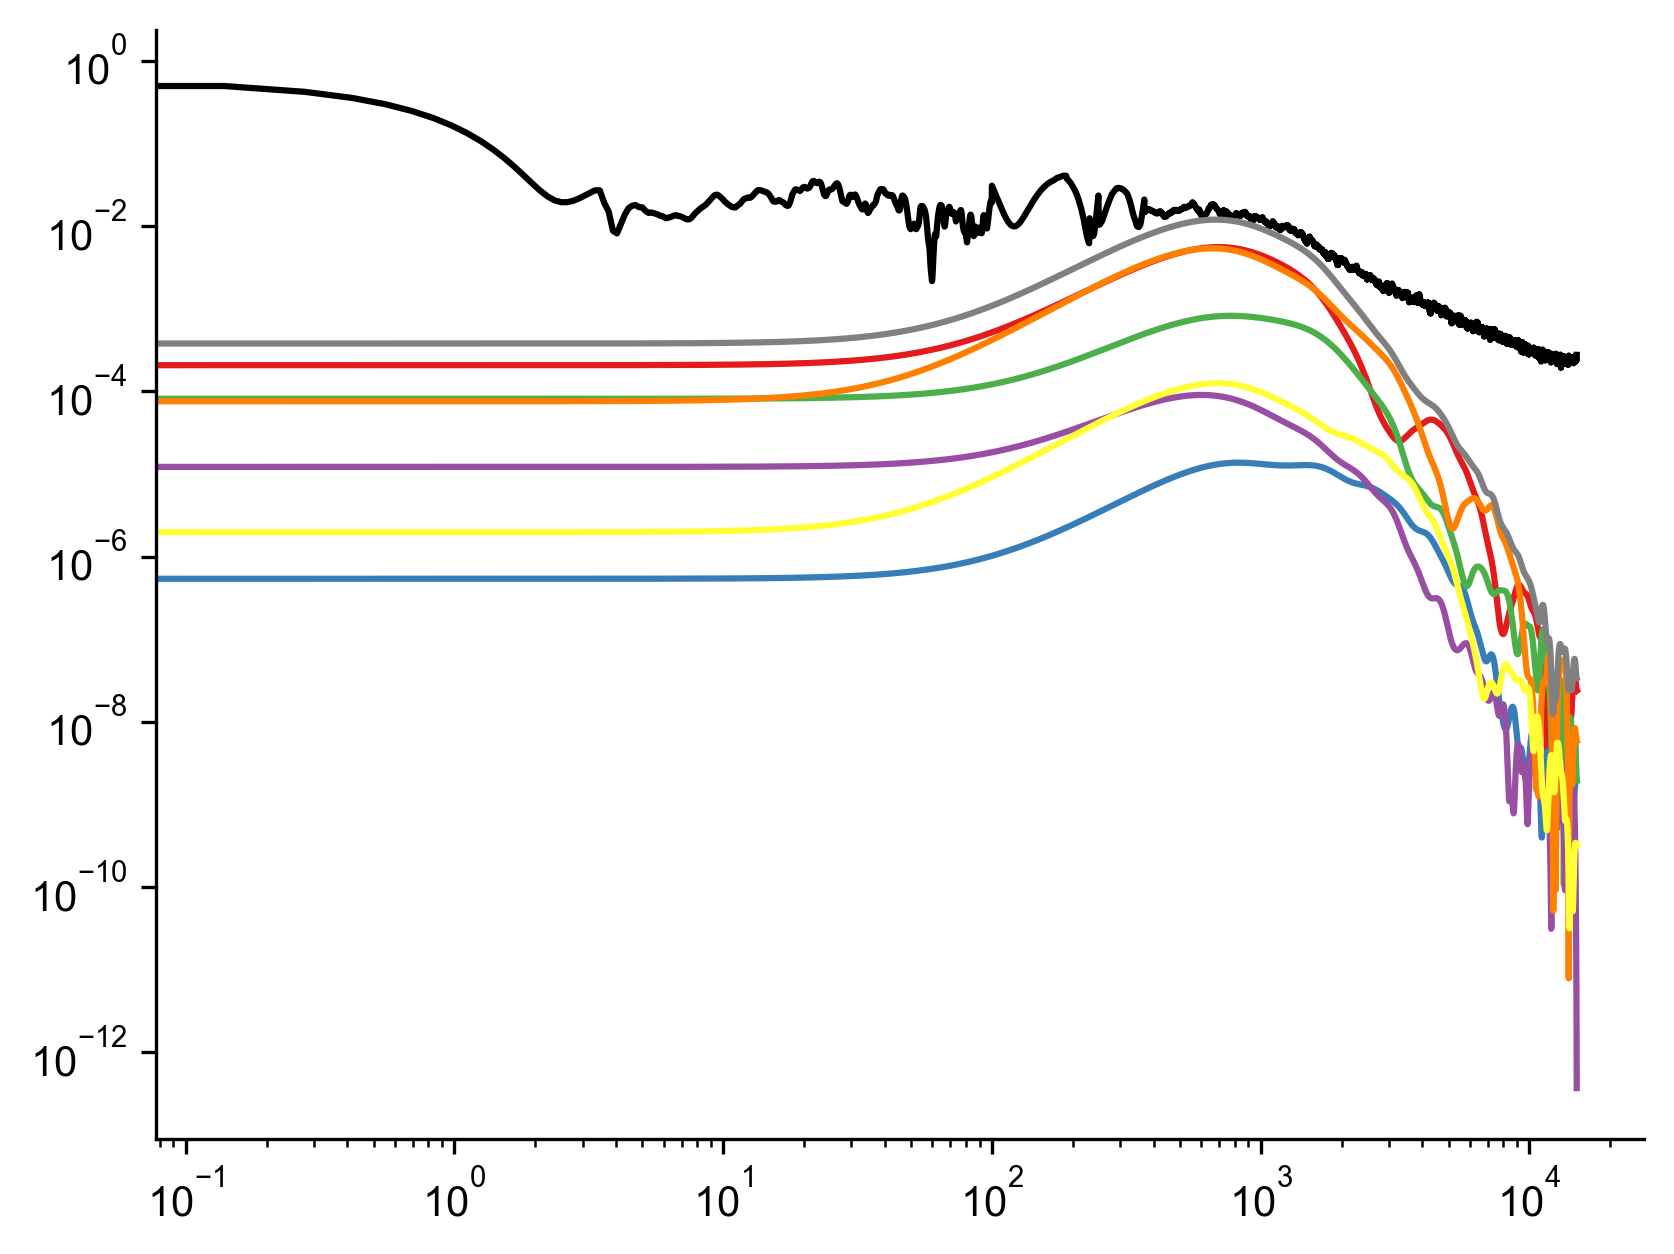

In [ ]:
plt.figure(dpi=300)
plt.loglog(mt_freqs, ch163_PSD_smooth, color='k')
plt.loglog(theor_freqs, chan163_theor_psds[0], color=cmap(0))
plt.loglog(theor_freqs, chan163_theor_psds[1], color=cmap(1))
plt.loglog(theor_freqs, chan163_theor_psds[2], color=cmap(2))
plt.loglog(theor_freqs, chan163_theor_psds[3], color=cmap(3))
plt.loglog(theor_freqs, chan163_theor_psds[4], color=cmap(4))
plt.loglog(theor_freqs, chan163_theor_psds[5], color=cmap(5))
plt.loglog(theor_freqs, np.array(chan163_theor_psds).sum(axis=0), color='gray')
#plt.xlim((100, 2000))
#plt.ylim((1e-5, 1))